# Sparkify Project - Data Exploration
Sparkify is a fake music streaming platform invented by Udacity. Here I will analyze a small dataset (128MB) made available by Udacity and containing customer data related to the Sparkify platform usage.

The goal of the project is to leverage the data made avaialbale to predict which customer are churning.

In [168]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, concat, lit, col , least
from pyspark.sql.functions import isnan, when
from pyspark.sql.functions import sum as Fsum 
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import unix_timestamp, to_timestamp, datediff
from pyspark.sql.functions import avg, stddev , count
from pyspark.sql.functions import asc, desc
from pyspark.sql.types import IntegerType, StringType, DoubleType, LongType, BooleanType, TimestampType, DateType
from pyspark.ml.feature import RegexTokenizer, VectorAssembler

import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns 
import scipy.stats as sp
from datetime import datetime as dt 
from datetime import timedelta as td

In [2]:
# create a Spark session
spark = SparkSession.builder \
        .master("local") \
        .appName("Sparkify_EDA") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. 
Below, I will be exploring the dataset, checking for invalid or missing data and get a cleaned dataset. 

In [3]:
data_path = "mini_sparkify_event_data.json"
df = spark.read.json(data_path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
# Schema of the dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Datatypes of each columns
df.schema.fields

[StructField(artist,StringType,true),
 StructField(auth,StringType,true),
 StructField(firstName,StringType,true),
 StructField(gender,StringType,true),
 StructField(itemInSession,LongType,true),
 StructField(lastName,StringType,true),
 StructField(length,DoubleType,true),
 StructField(level,StringType,true),
 StructField(location,StringType,true),
 StructField(method,StringType,true),
 StructField(page,StringType,true),
 StructField(registration,LongType,true),
 StructField(sessionId,LongType,true),
 StructField(song,StringType,true),
 StructField(status,LongType,true),
 StructField(ts,LongType,true),
 StructField(userAgent,StringType,true),
 StructField(userId,StringType,true)]

In [6]:
# number of entries in dataset 
df.count()

286500

In [7]:
# Counting null values in each column
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



There seem to be no null values programmatically recognizable. Let's look at the different column entries distribution.

## Exploring the columns of the dataset

In [8]:
# identify string columns
string_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]

In [9]:
string_columns

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

In [10]:
# identify numerical columns
numerical_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, DoubleType) or isinstance(f.dataType, LongType)]

In [11]:
numerical_columns

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [12]:
# Get a sample of rows for string columns 
df.select(string_columns).show(5)

+----------------+---------+---------+------+--------+-----+--------------------+------+--------+--------------------+--------------------+------+
|          artist|     auth|firstName|gender|lastName|level|            location|method|    page|                song|           userAgent|userId|
+----------------+---------+---------+------+--------+-----+--------------------+------+--------+--------------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M| Freeman| paid|     Bakersfield, CA|   PUT|NextSong|           Rockpools|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|    Long| free|Boston-Cambridge-...|   PUT|NextSong|              Canada|"Mozilla/5.0 (Win...|     9|
|    Adam Lambert|Logged In|    Colin|     M| Freeman| paid|     Bakersfield, CA|   PUT|NextSong|   Time For Miracles|Mozilla/5.0 (Wind...|    30|
|          Enigma|Logged In|    Micah|     M|    Long| free|Boston-Cambridge-...|   PUT|NextSong|Knocking On Forbi...|

In [13]:
# How many users are stored in the dataset? 
df.select('userID').dropDuplicates().count()

226

In [14]:
# Counting entries by userId 
df.groupBy('userId').agg(count(df.userId)).orderBy('count(UserId)',ascending=False).show()

+------+-------------+
|userId|count(userId)|
+------+-------------+
|    39|         9632|
|      |         8346|
|    92|         7230|
|   140|         6880|
|300011|         5732|
|   124|         4825|
|300021|         4659|
|300017|         4428|
|    85|         4370|
|    42|         4257|
|200023|         3769|
|     6|         3761|
|    29|         3603|
|    54|         3437|
|   100|         3214|
|     9|         3191|
|   126|         3102|
|300015|         3051|
|    91|         3014|
|    98|         2891|
+------+-------------+
only showing top 20 rows



It seems there are 8346 entries with no userId, let's investigate those.

In [15]:
# Investigating entries with no userId
df.filter("userId = ''").show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [17]:
df.filter("userId = ''").select('userId','auth','registration','method','page','level').groupby('registration','auth','level','page').count().show()

+------------+----------+-----+-------------------+-----+
|registration|      auth|level|               page|count|
+------------+----------+-----+-------------------+-----+
|        null|Logged Out| free|              Error|    3|
|        null|     Guest| free|               Help|   23|
|        null|Logged Out| paid|               Help|  190|
|        null|Logged Out| free|               Home| 1363|
|        null|Logged Out| paid|              Login| 2299|
|        null|     Guest| free|              Error|    1|
|        null|     Guest| free|           Register|   18|
|        null|     Guest| free|              About|   14|
|        null|Logged Out| free|              Login|  942|
|        null|Logged Out| free|               Help|   59|
|        null|     Guest| free|Submit Registration|    5|
|        null|     Guest| free|               Home|   36|
|        null|Logged Out| paid|               Home| 2976|
|        null|Logged Out| free|              About|  153|
|        null|

The entries with null userId seem to be from guest users or logged out users, none are registered. Let's drop those entries. 

In [18]:
# Let's drop the guest entries as part of first data transformation step 
def drop_null_userId(df):
    df = df.filter("userId <> ''")
    return df 
df = drop_null_userId(df)

In [19]:
# Investigate userId column again 
df.groupBy('userId').agg(count(df.userId)).orderBy('count(UserId)',ascending=True).show()

+------+-------------+
|userId|count(userId)|
+------+-------------+
|   156|            6|
|   135|            6|
|   125|           11|
|100011|           23|
|300003|           35|
|100024|           36|
|    22|           40|
|   133|           44|
|100006|           44|
|    90|           45|
|    68|           48|
|   134|           52|
|   122|           62|
|    64|           68|
|    34|           73|
|100017|           75|
|200007|           76|
|100003|           78|
|   116|           79|
|200012|           84|
+------+-------------+
only showing top 20 rows



In [20]:
# Are there other entries with null registration? 
df.filter("registration = ''").select('userId','registration','method','page','level').groupby('registration','level','page').count().show()

+------------+-----+----+-----+
|registration|level|page|count|
+------------+-----+----+-----+
+------------+-----+----+-----+



No other null values in registration column. 

Investigating other null values in string columns.

In [31]:
try:
    columns = string_columns.remove('userId')
except: 
    columns = string_columns
        
for column in columns :
    print('Column {} has {} null values.'.format(column, df.filter(col(column)=='').count()))

Column artist has 0 null values.
Column auth has 0 null values.
Column firstName has 0 null values.
Column gender has 0 null values.
Column lastName has 0 null values.
Column level has 0 null values.
Column location has 0 null values.
Column method has 0 null values.
Column page has 0 null values.
Column song has 0 null values.
Column userAgent has 0 null values.


It looks good for now regarding missing values, let's investigate now the format of numerical columns.

In [34]:
# Looking at format and statistics of numerical columns 
df.select(numerical_columns).describe().show()

+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|           length|        registration|         sessionId|            status|                  ts|
+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|  count|            278154|           228108|              278154|            278154|            278154|              278154|
|   mean|114.89918174824018|249.1171819778458|1.535358834084427...|1042.5616241362698|209.10321620397335|1.540958915431871...|
| stddev|  129.851729399489|99.23517921058361| 3.291321616327586E9| 726.5010362219813|30.151388851328214|1.5068287123306298E9|
|    min|                 0|          0.78322|       1521380675000|                 1|               200|       1538352117000|
|    max|              1321|       3024.66567|       1543247354000|              2474|               404|      

Let's transform the registration and ts columns to datetime format.

In [36]:
# Let's convert registration and ts from timestamps to datetimes
from_ts_to_date = udf(lambda x: dt.fromtimestamp(x / 1000.0), TimestampType())

In [37]:
df = df.withColumn('registration_date', from_ts_to_date(col('registration')))
df = df.withColumn('event_date', from_ts_to_date(col('ts')))

Let's now proceed to a preliminary exploration of the dataset.

# Exploratory Data Analysis

In [38]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- registration_date: timestamp (nullable = true)
 |-- event_date: timestamp (nullable = true)



In [69]:
# How many entries do we have?
print('We have {} entries in the dataset.'.format(df.count()))

We have 278154 entries in the dataset.


In [67]:
# How many users are being captured?
print('We have {} users in the dataset.'.format(df.select('userId').dropDuplicates().count()))

We have 225 users in the dataset.


In [68]:
# How many sessions are recorded?
print('We have {} sessions in the dataset.'.format(df.select('sessionId').dropDuplicates().count()))

We have 2312 sessions in the dataset.


In [39]:
# How many artists are recorded?
print('We have {} artists recorded.'.format(df.select('artist').dropDuplicates().count()))

We have 17656 artists recorded.


In [76]:
# How is gender encoded? and what is the share among our users? 
userCount = df.select('userId').dropDuplicates().count()
df.select('userId','gender').dropDuplicates().groupby('gender').count().withColumn('share',col('count')/lit(userCount)).show()

+------+-----+------------------+
|gender|count|             share|
+------+-----+------------------+
|     F|  104|0.4622222222222222|
|     M|  121|0.5377777777777778|
+------+-----+------------------+



In [77]:
# What are the different levels, and how many users use each? 
df.select('userId','level').dropDuplicates().groupby('level').count().withColumn('share',col('count')/lit(userCount)).show()

+-----+-----+------------------+
|level|count|             share|
+-----+-----+------------------+
| free|  195|0.8666666666666667|
| paid|  165|0.7333333333333333|
+-----+-----+------------------+



87% of all users have been using the free offer, which means that 13% of users have exclusively used the paid version in the dataset provided. 
On the other hand, 73% have used the paid version, which means that 27% have used the free offer only.

In [46]:
# What are the different location? 
df.select('location').dropDuplicates().show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



In [66]:
# How many locations are stored?
print('There are {} locations represented in the dataset.'.format(df.select('location').dropDuplicates().count()))

There are 114 locations represented in the dataset.


Text(0, 0.5, 'Cumulative user share')

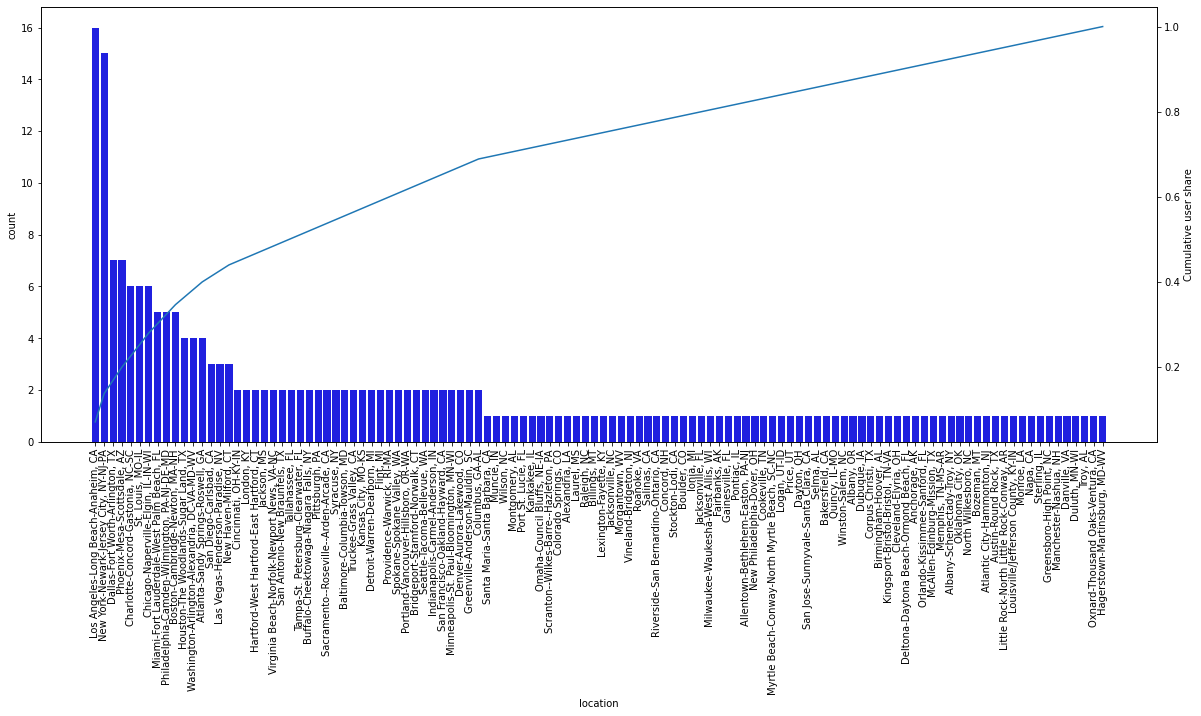

In [94]:
#How many users per location are there? 
plt.figure(figsize=[20,8])
user_location = df.select('userId','location').dropDuplicates().groupby('location').count().toPandas().sort_values(by='count',ascending=False)
user_location_cumsum = pd.DataFrame(columns = ['location','cumshare'], index = user_location.index)
user_location_cumsum['cumshare'] = user_location['count'].cumsum()/userCount
user_location_cumsum['location'] = user_location['location']
sns.barplot(data = user_location, x='location',y='count', color='b');
plt.xticks(rotation=90);
ax2 = plt.twinx()
ax2.plot(user_location_cumsum.location, user_location_cumsum.cumshare)
ax2.set_ylabel('Cumulative user share')

Location seems to be split between states and cities, let's create a state column.

In [100]:
def take_last_2_char(x):
    return x[-2:]
take_last_2_char_udf = udf(lambda x:take_last_2_char(x), StringType())

In [103]:
df=df.withColumn('location_state', take_last_2_char_udf(col('location')))

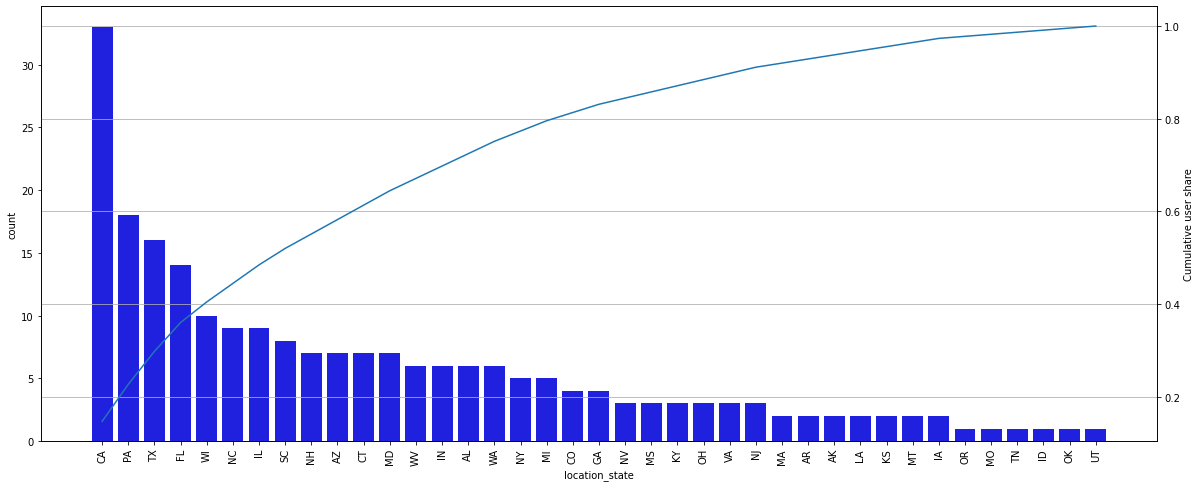

In [105]:
#How many users per state are there? 
plt.figure(figsize=[20,8])
user_location = df.select('userId','location_state').dropDuplicates().groupby('location_state').count().toPandas().sort_values(by='count',ascending=False)
user_location_cumsum = pd.DataFrame(columns = ['location_state','cumshare'], index = user_location.index)
user_location_cumsum['cumshare'] = user_location['count'].cumsum()/userCount
user_location_cumsum['location_state'] = user_location['location_state']
sns.barplot(data = user_location, x='location_state',y='count', color='b');
plt.xticks(rotation=90);
ax2 = plt.twinx()
ax2.plot(user_location_cumsum.location_state, user_location_cumsum.cumshare)
ax2.set_ylabel('Cumulative user share')
plt.grid()

The user distribution across states is highly skewed, we see that the first 10 states cover about 60% of the population, some states have less than 3 users represented in the dataset.

In [107]:
# What are methods? 
df.select('method').dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



Method seems to be some sort of web variable. 

In [111]:
#Which pages are the most used? 
pages = df.select('page').groupby('page').count().toPandas().sort_values(by='count',ascending=False)
pages['proportion']=pages['count']/pages['count'].sum()*100

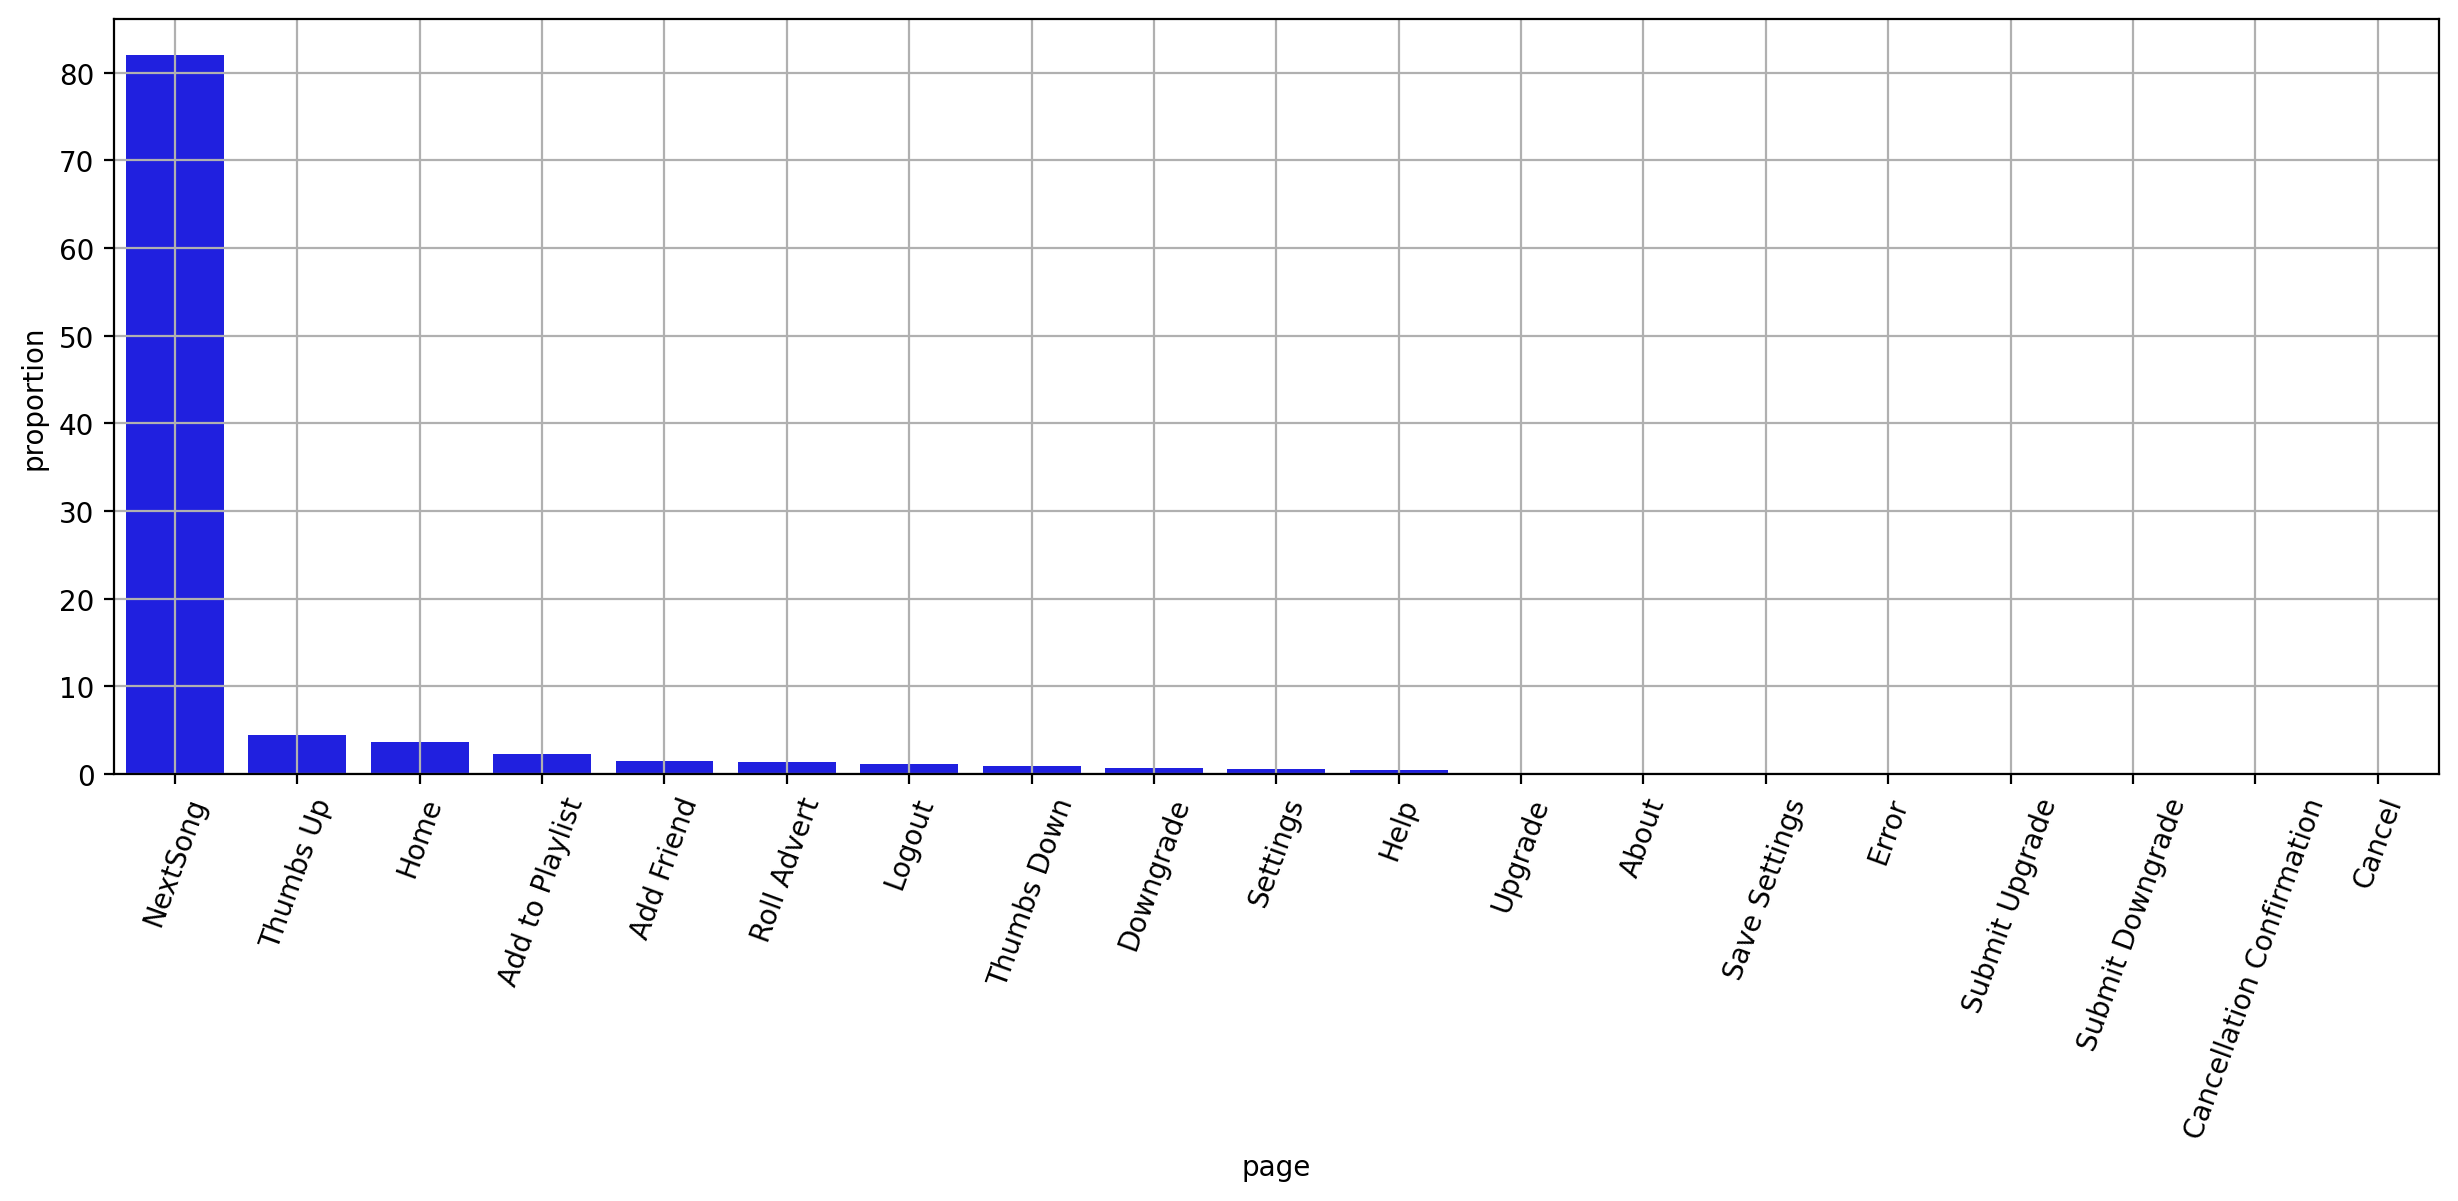

In [113]:
fig, ax = plt.subplots(1,1,figsize=(15,5), dpi = 200)
sns.barplot(data=pages, x='page',y='proportion', color='b');
plt.xticks(rotation=70)
plt.grid()

Page "NextSong" is definitely the most used, then use of "Thumbs Up" and "Home".

In [115]:
# How is the page use prevalence per user? 
pages_by_user = df.select('userId','page').dropDuplicates().groupby('page').count().toPandas().sort_values(by='count',ascending=False)
pages_by_user['proportion']=pages_by_user['count']/userCount

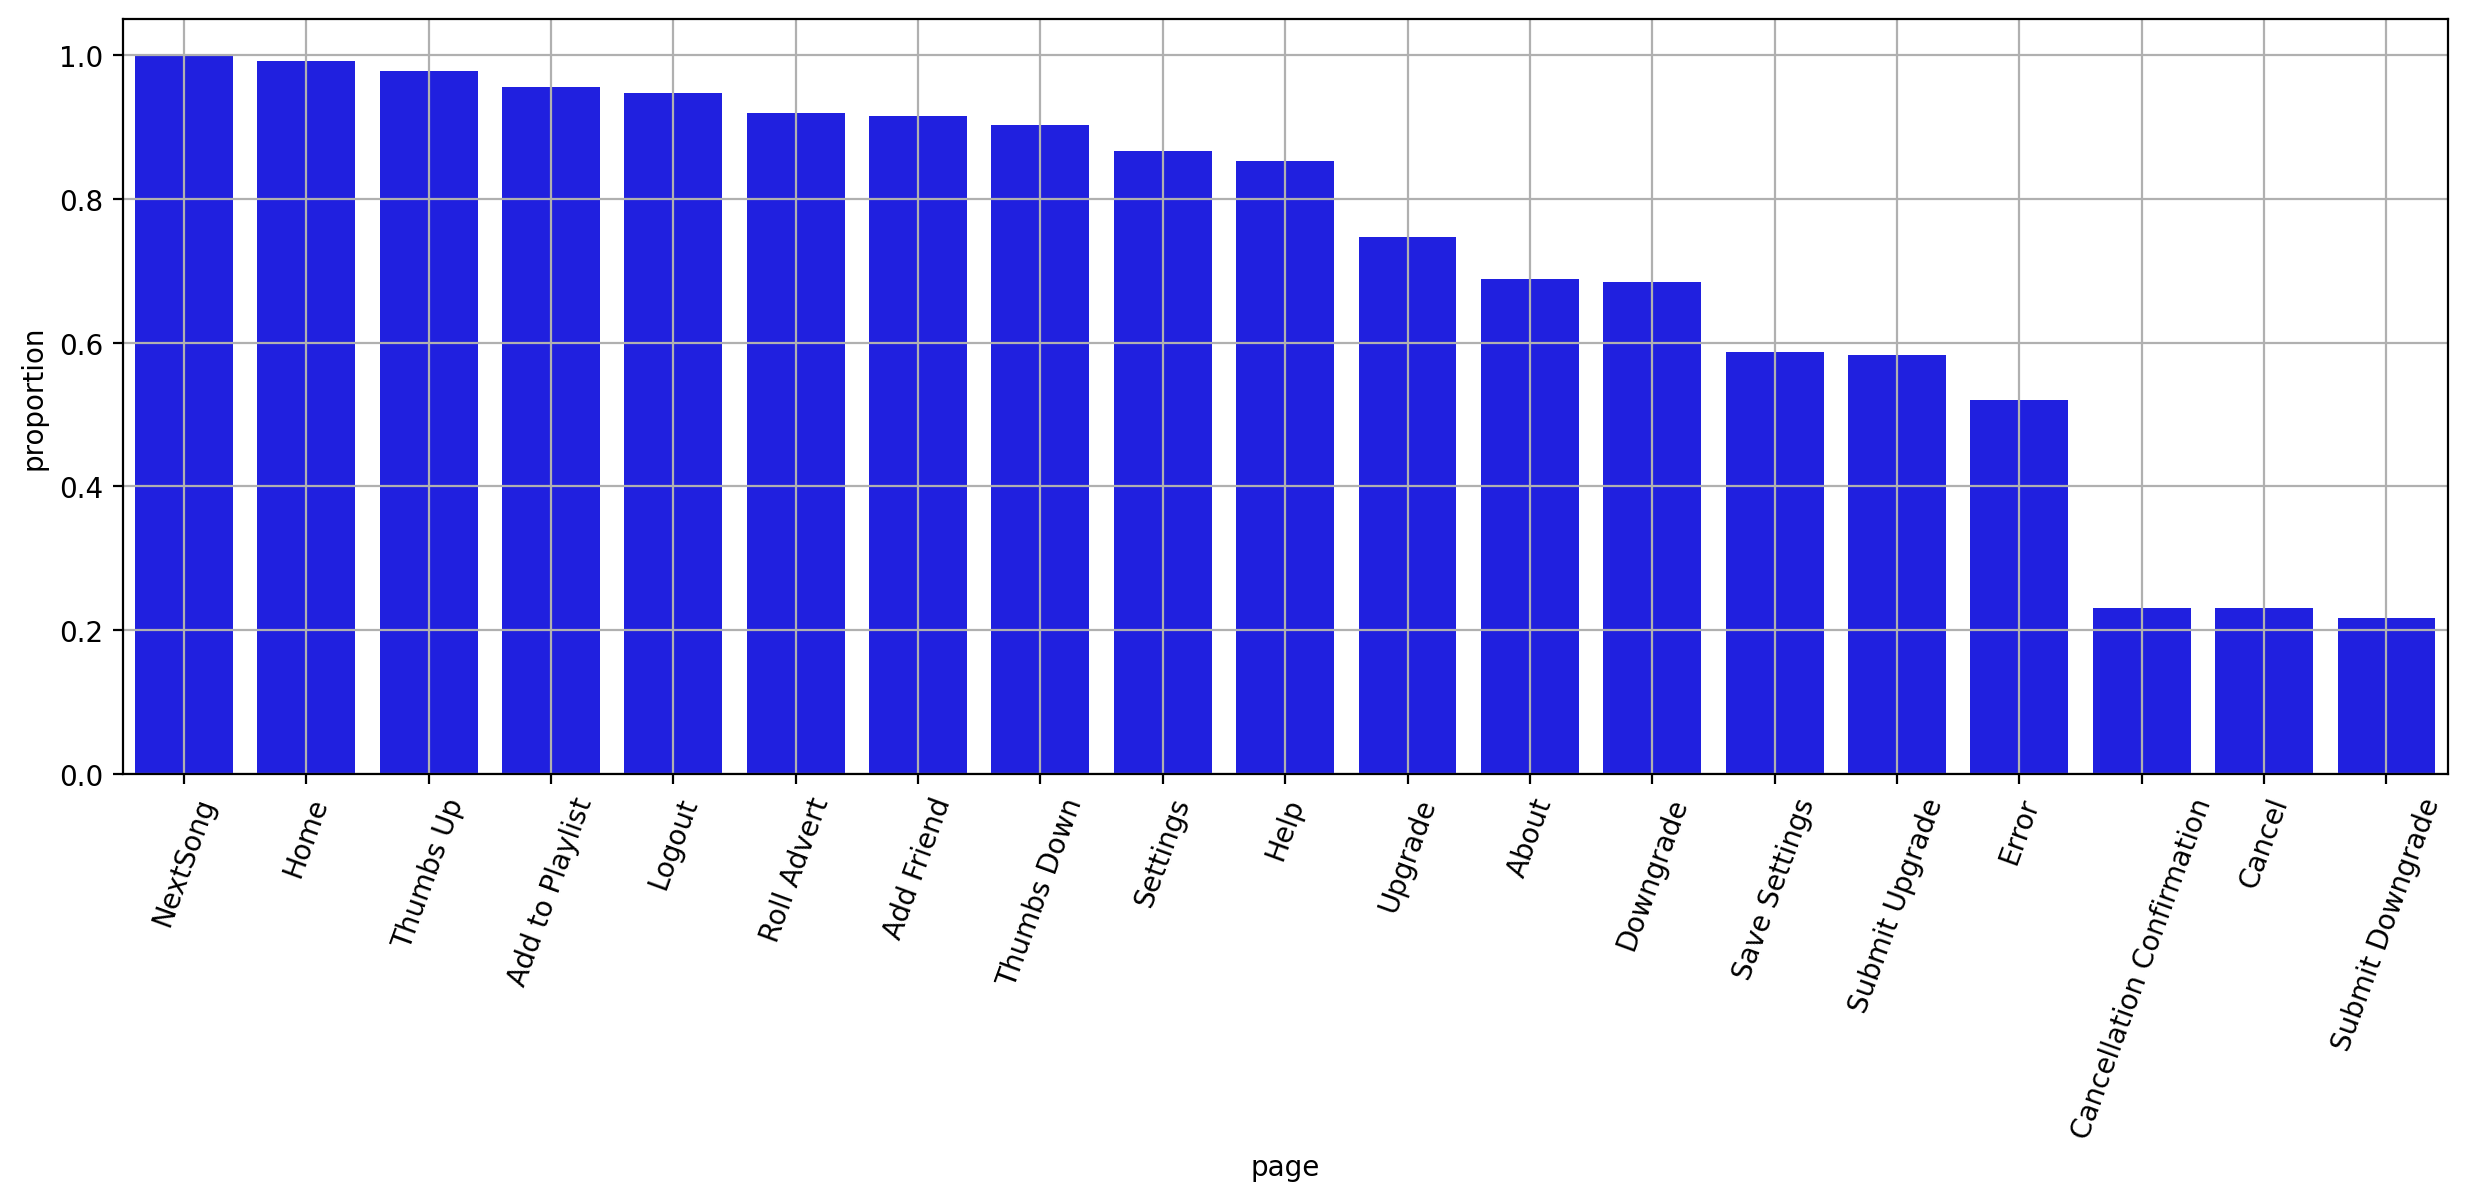

In [116]:
fig, ax = plt.subplots(1,1,figsize=(15,5), dpi = 200)
sns.barplot(data=pages_by_user, x='page',y='proportion', color='b');
plt.xticks(rotation=70)
plt.grid()

Seems like everyone uses "NextSong" at least once, the pages used by the least amount of users are "Cancellation Confirmation", "Cancel" and "Submit Downgrade" which are the churning signals.

In [118]:
# What is in status?
df.select('page','status').dropDuplicates().show()

+--------------------+------+
|                page|status|
+--------------------+------+
|           Downgrade|   200|
|       Save Settings|   307|
|                Help|   200|
|Cancellation Conf...|   200|
|            Settings|   200|
|          Add Friend|   307|
|             Upgrade|   200|
|         Roll Advert|   200|
|      Submit Upgrade|   307|
|               Error|   404|
|                Home|   200|
|               About|   200|
|     Add to Playlist|   200|
|              Logout|   307|
|         Thumbs Down|   307|
|              Cancel|   307|
|           Thumbs Up|   307|
|            NextSong|   200|
|    Submit Downgrade|   307|
+--------------------+------+



Status 404 relates to Error page, status seems to be some sort of web page type of encoding.

In [125]:
df.select('UserAgent').dropDuplicates().collect()[0][0]

'"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'

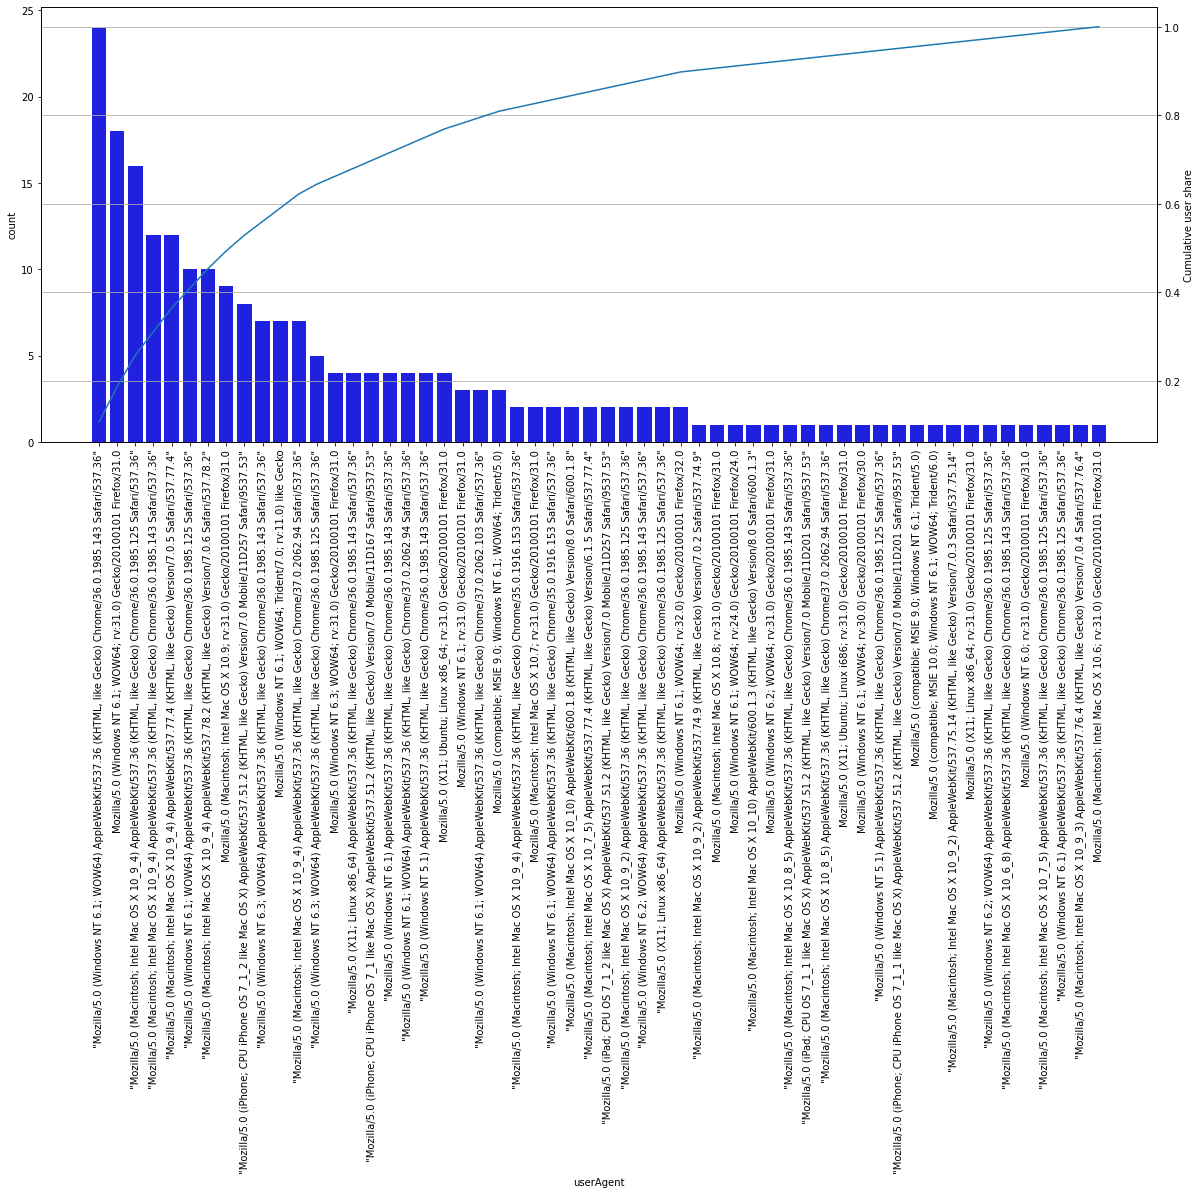

In [121]:
# What is in userAgent, and what is the user distribution across that variable?
plt.figure(figsize=[20,8])
user_agent = df.select('userId','userAgent').dropDuplicates().groupby('userAgent').count().toPandas().sort_values(by='count',ascending=False)
user_userAgent_cumsum = pd.DataFrame(columns = ['userAgent','cumshare'], index = user_agent.index)
user_userAgent_cumsum['cumshare'] = user_agent['count'].cumsum()/userCount
user_userAgent_cumsum['userAgent'] = user_agent['userAgent']
sns.barplot(data = user_agent, x='userAgent',y='count', color='b');
plt.xticks(rotation=90);
ax2 = plt.twinx()
ax2.plot(user_userAgent_cumsum.userAgent, user_userAgent_cumsum.cumshare)
ax2.set_ylabel('Cumulative user share')
plt.grid()

One can extract the machine type used by the user from userAgent. Let's do that. 

In [144]:
# Creating device type
def get_device_type(x):
    if 'Macintosh' in x:
        return 'Mac'
    elif 'Windows' in x:
        return 'Windows'
    elif 'Linux' in x:
        return 'Android'
    elif 'iPhone' in x:
        return 'iPhone'
    elif 'iPad' in x:
        return 'iPad'
    else: 
        return 'Unknown'

get_device_udf = udf(lambda x:get_device_type(x), StringType())

In [145]:
df = df.withColumn('device', get_device_udf(col('userAgent')))

In [146]:
df.select('userId','device').dropDuplicates().groupby('device').count().show()

+-------+-----+
| device|count|
+-------+-----+
|   iPad|    3|
| iPhone|   13|
|    Mac|   86|
|Android|   12|
|Windows|  111|
+-------+-----+



Let's create a Mobile vs Desktop split.

In [147]:
df = df.withColumn('experience',when(col('device').isin(['iPhone','iPad','Android']), 'Mobile').otherwise('Desktop'))

In [148]:
df.select('userId','experience').dropDuplicates().groupby('experience').count().show()

+----------+-----+
|experience|count|
+----------+-----+
|    Mobile|   28|
|   Desktop|  197|
+----------+-----+



A large majority of users use a Desktop interface to access the music streaming platform. Very few are using it on a mobile device.

Let's now look more in detail into sessions data.

In [149]:
# How do events length in sessions distribute (let's look at it in minutes)?
event_duration_minutes = df.withColumn('event_duration_minutes', col('length')/60).select('event_duration_minutes')
event_duration_minutes.describe().show()
event_duration_minutes_p = event_duration_minutes.toPandas()

+-------+----------------------+
|summary|event_duration_minutes|
+-------+----------------------+
|  count|                228108|
|   mean|     4.151953032964254|
| stddev|    1.6539196535097305|
|    min|  0.013053666666666667|
|    max|            50.4110945|
+-------+----------------------+



In [150]:
def plot_distribution(values,value_name, value_unit,show_mean=True,log_scale=False):
    fig=plt.figure(figsize=(10,4), dpi= 200, facecolor='w', edgecolor='k')
    ax = sns.histplot(values, log_scale=log_scale)
   # ax.set_xlim([0,10])
    ax.grid()
    if show_mean:
        m = values.mean()[0]
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xspan = xlim[1]-xlim[0]
        yspan = ylim[1]-ylim[0]
        plt.axvline(x=m,color='r')
        plt.text(x=0.05*xspan+m,y=0.5*yspan+ylim[0],s='Mean {} = {:.0f} {}.'.format(value_name,m,value_unit))
        ax.set_xlabel(value_name+' in '+value_unit)


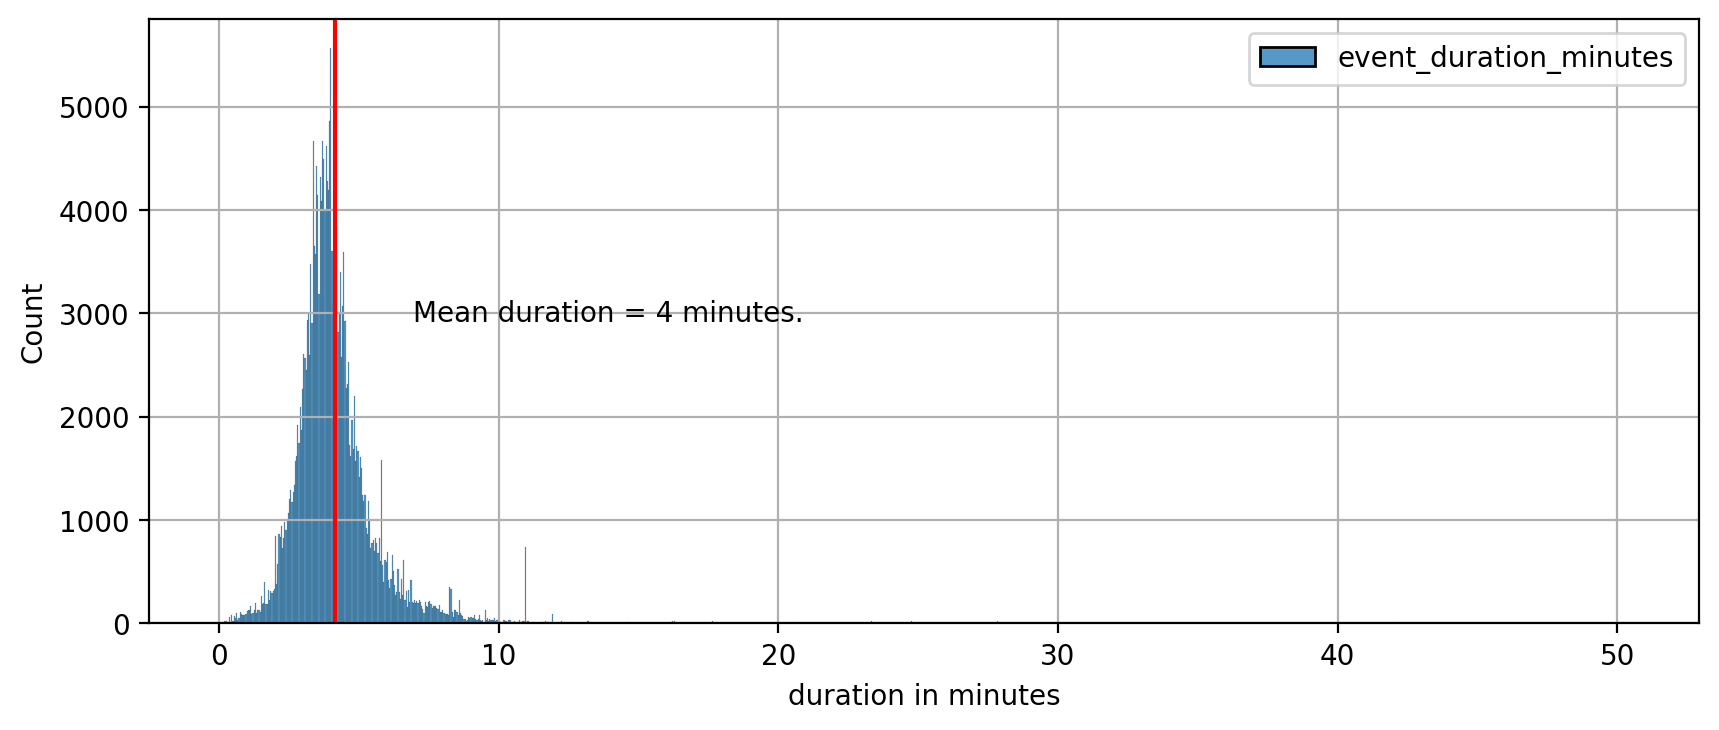

In [151]:
# Distribution of session duration
plot_distribution(event_duration_minutes_p.dropna(),'duration','minutes')

There are 228108 events logged, the events have an average duration of 4.15 minutes, a standard deviation of 1.65 minutes, a minimum duration of 0.01 minutes and a maximum duration of 50 minutes.

In [152]:
# How do session length distribute?
session_length = df.withColumn('session_duration_minutes', Fsum('length').over(Window.partitionBy('SessionId'))/60).select('sessionId','session_duration_minutes').dropDuplicates()

In [153]:
session_length.select('session_duration_minutes').describe().show()

+-------+------------------------+
|summary|session_duration_minutes|
+-------+------------------------+
|  count|                    2253|
|   mean|       420.3700410312178|
| stddev|      468.61949472266224|
|    min|               2.5578155|
|    max|       4462.635548500001|
+-------+------------------------+



The average session duration is about 7 hours (420 minutes), the minimum duration is about 2 minutes, and teh maximum duration is about 74 hours. 

In [154]:
sess_length_minutes = session_length.select('session_duration_minutes').toPandas()

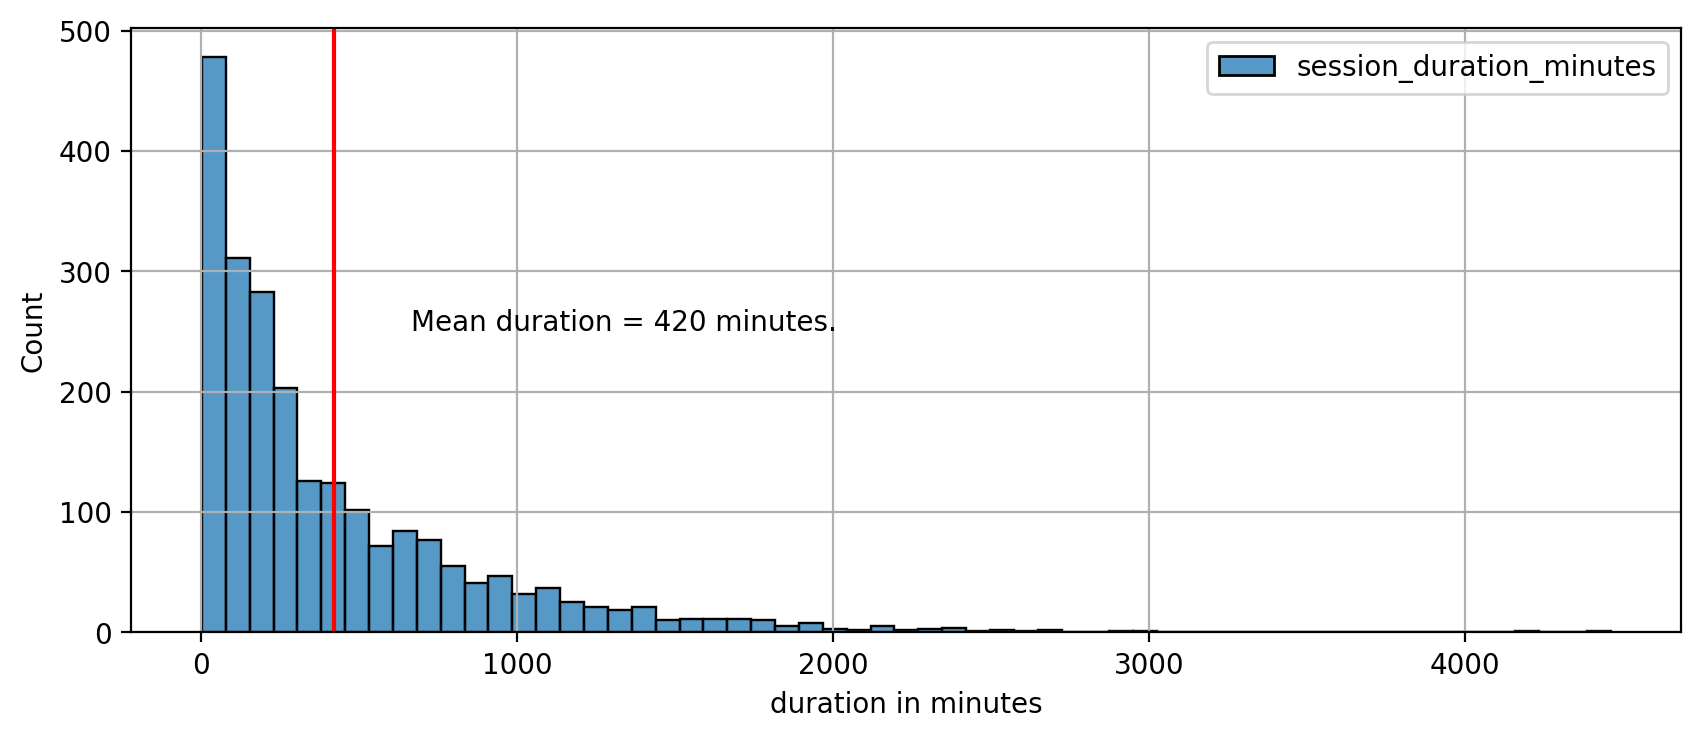

In [155]:
plot_distribution(sess_length_minutes.dropna(),'duration','minutes')

In [156]:
# How do the session activities distribute over time? Let's look at event date as each event has a logged timestamp
events = df.select('event_date').toPandas()

In [157]:
dates = events.event_date

In [158]:
# How many days spans the data availability? 
difference = dates.max()- dates.min()
difference.days

63

In [159]:
def plot_time_distribution(dates, title,xlabel,ylabel):
    
    difference = dates.max()- dates.min()
    fig, ax = plt.subplots(1,1,figsize=(10,5), dpi=200)
    sns.histplot(dates, bins = difference.days, ax=ax,kde=False,color = 'r',alpha=0.6)
    ticks_locations, _ = plt.xticks();
    
    # Get the labels for those positions
    labels = [dt.fromordinal(int(t)).date() for t in ticks_locations]
    plt.xticks(ticks_locations, labels, rotation=45)
    plt.title(title);
    plt.grid()
    ax.set_xlim([dates.min().date()-td(days=1),dates.max().date()])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax2 = plt.twinx()
    ax2 = sns.kdeplot(dates, ax=ax2)
    ax2.set_ylabel('density')
    return fig, ax, ax2 
        

(<Figure size 2000x1000 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff02147d978>)

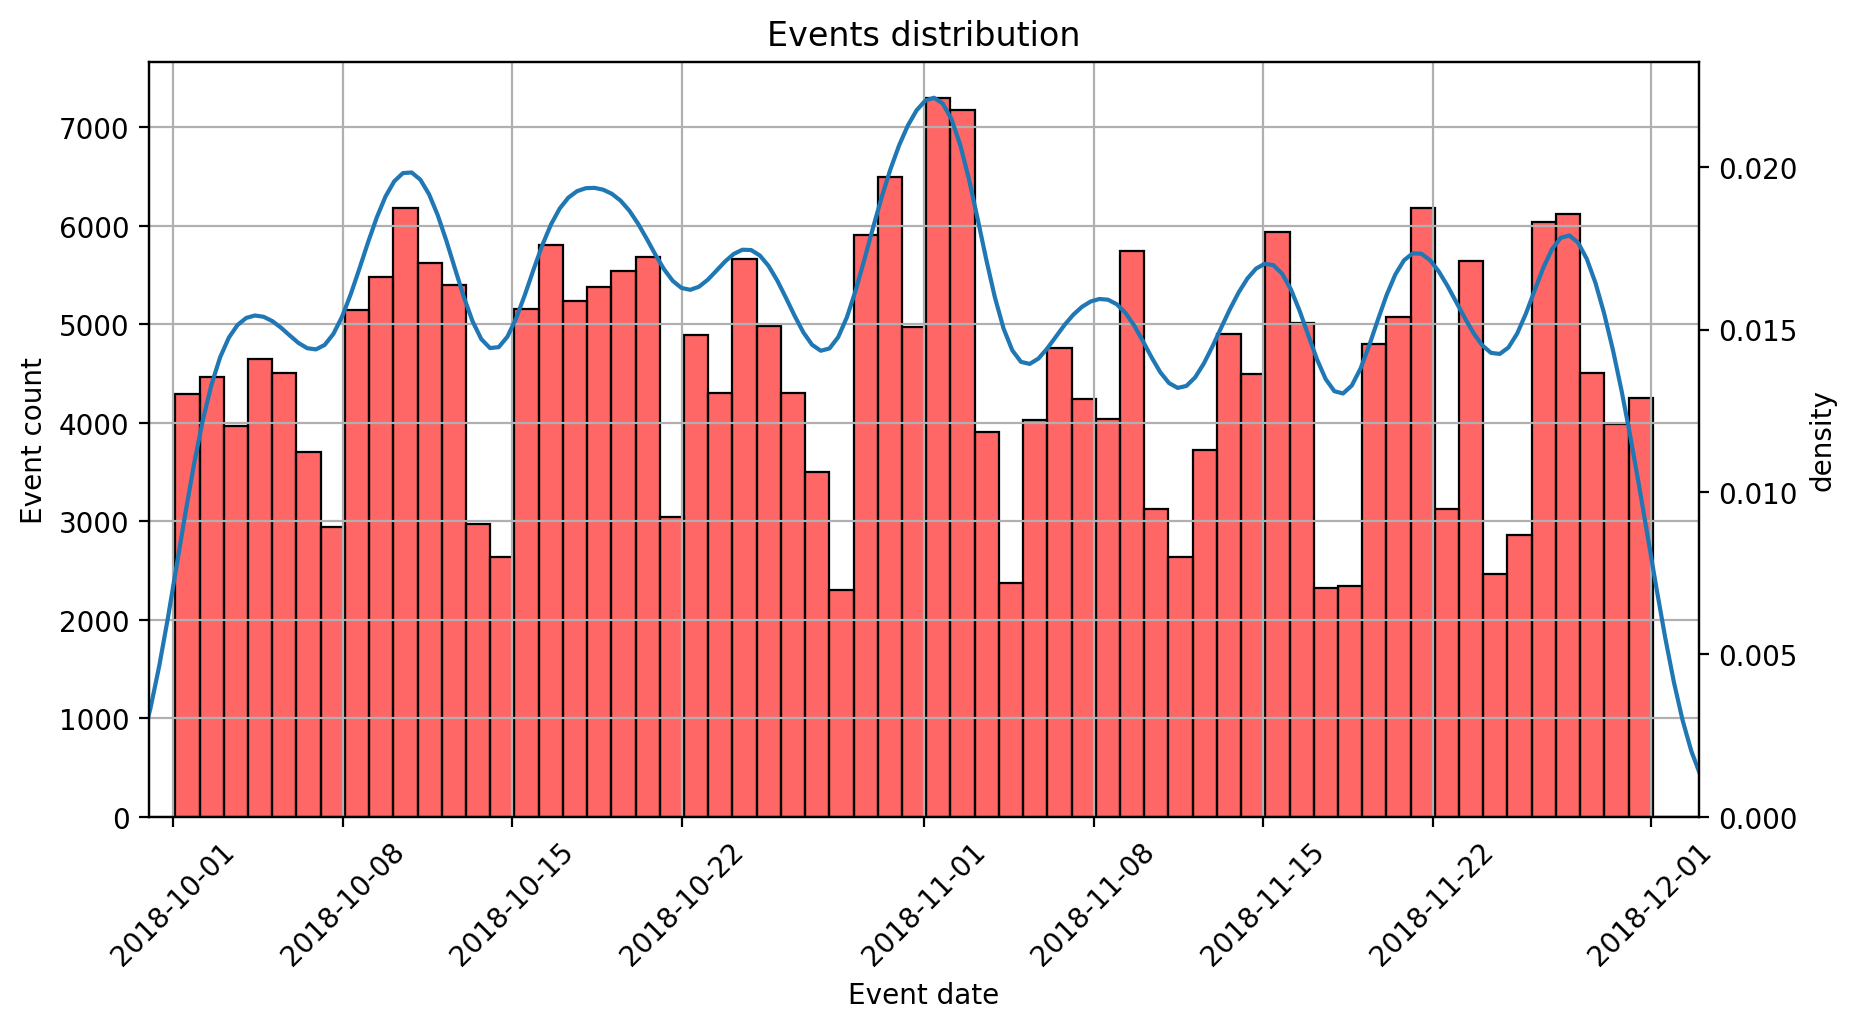

In [160]:
# Extracting the sessions distributions 
plot_time_distribution(events.event_date,title="Events distribution",xlabel='Event date',ylabel='Event count')

The dataset spans over 63 days of data, from Monday 1st October 2018 at 2 am until Monday 3rd December 2018 at 2 am. 
We see a clear 7 day periodicity, with a drop of session counts on sundays.  

In [162]:
# checking the distribution of user acquisition over time using registration_date
cohorts = df.select('userId','registration_date').dropDuplicates().select('registration_date').toPandas()

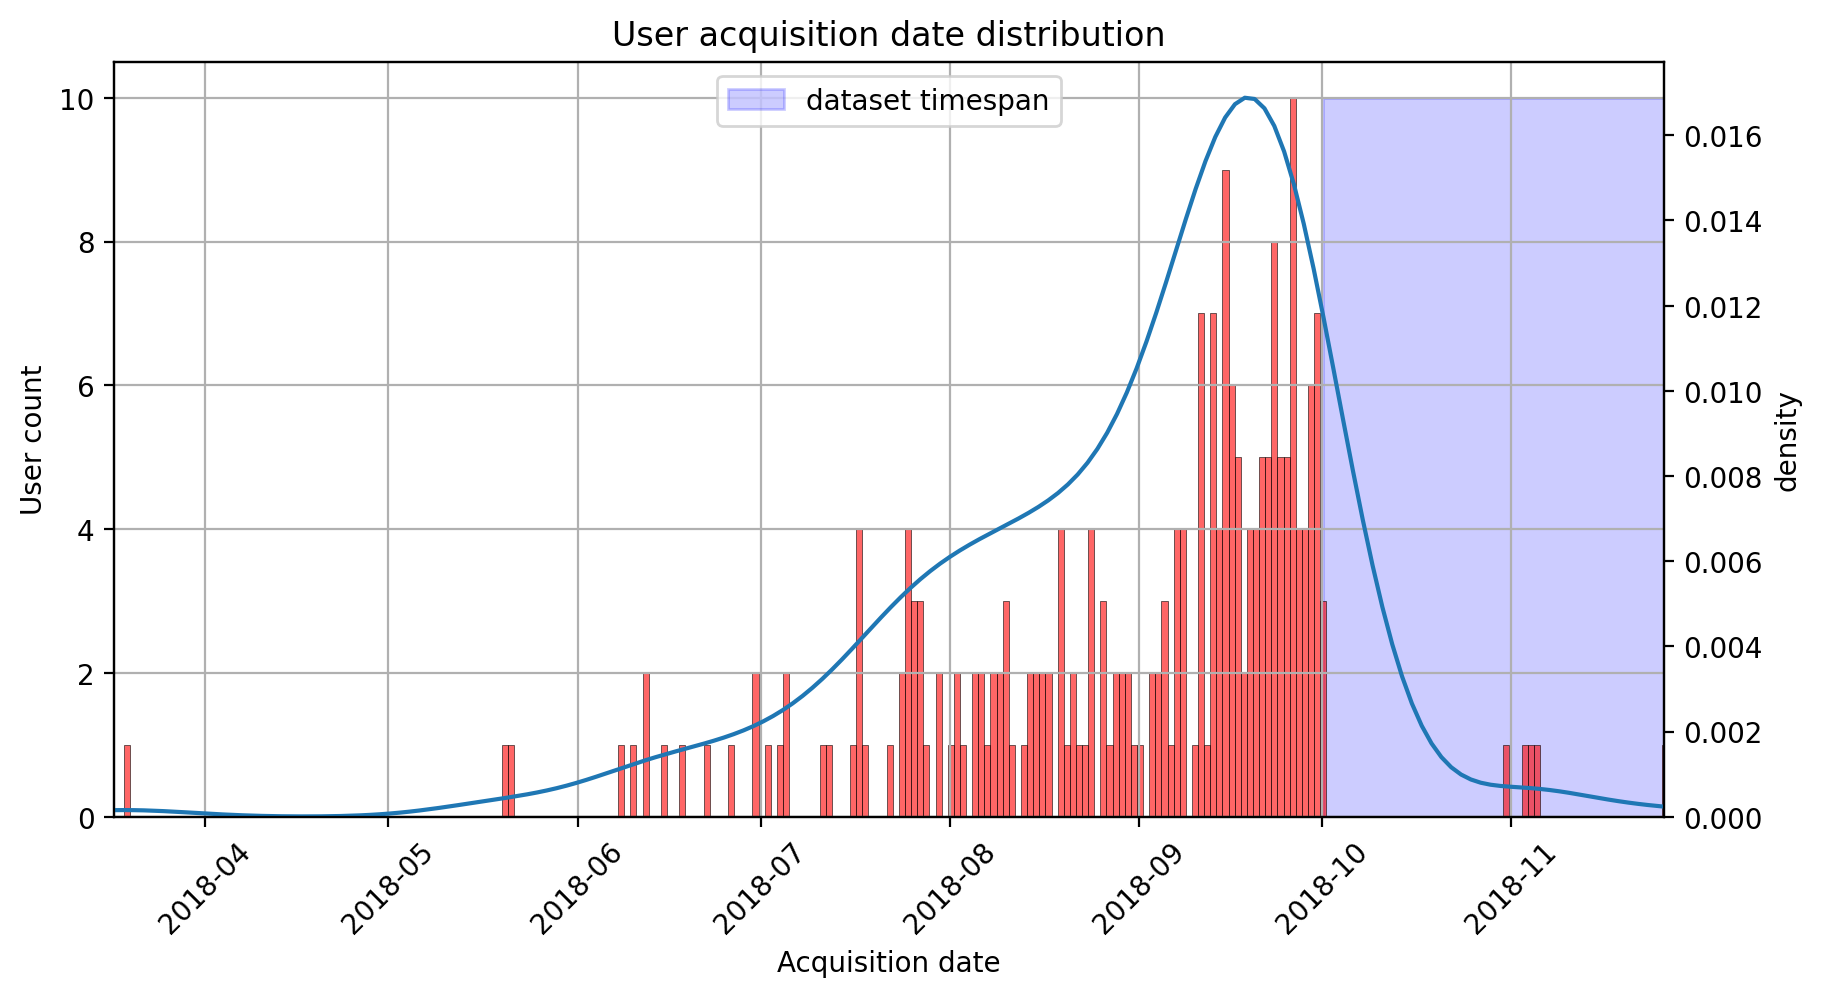

In [163]:
fig, ax, ax2 = plot_time_distribution(cohorts.registration_date,title="User acquisition date distribution",xlabel='Acquisition date',ylabel='User count')
ax.fill_between([events.event_date.min(),events.event_date.max()], [10,10],alpha = 0.2 ,color='b', label='dataset timespan')
ax.legend(loc = 'upper center')

We have very few users acquired in late part of the time period of the user data availability. In order to have sufficient user data to infer churn, we may need to drop those users from the training data to not bias the model with users not having enough data available compared to the others. Let's first verify the validity of the registration date.

In [166]:
# checking that registration_date is always before the first event recorded for a given user 
df.filter(datediff(col('event_date'),col('registration_date'))<0).select('userId').dropDuplicates().show()

+------+
|userId|
+------+
|   155|
|   154|
|   152|
+------+



Seems like 3 users have some recorded events before their registration date, let's correct the registration date for those users. 

In [169]:
df = df.withColumn('registration_date_cor', least(col('registration_date'),col('min_event_date')))

Let's now drop users that have registration date within the data collection window since they are so few. 

In [172]:
# Dropping users acquired after the start of the data collection window
data_min_date = df.select('min_event_date').agg(Fmin('min_event_date')).collect()[0][0]
df = df.where(col('registration_date_cor') <= data_min_date)

In [173]:
# checking the distribution of user acquisition over time using registration_date_cor
cohorts = df.select('userId','registration_date_cor').dropDuplicates().select('registration_date_cor').toPandas()

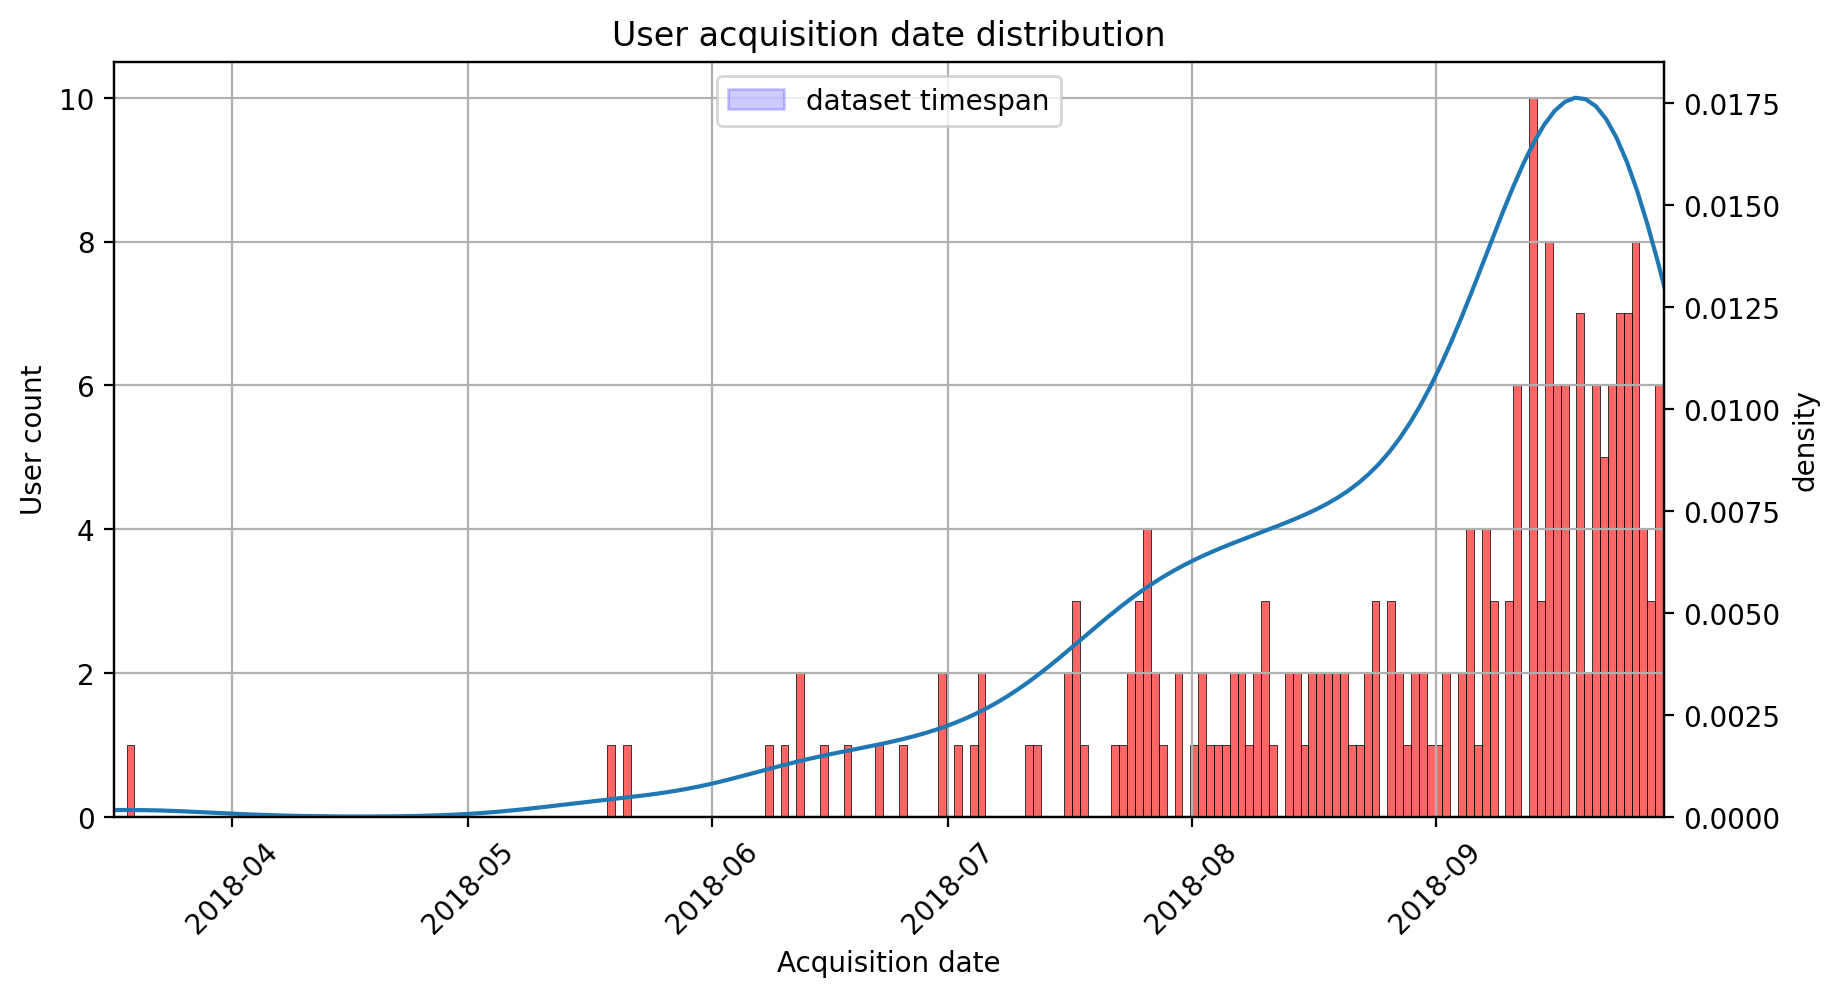

In [174]:
fig, ax, ax2 = plot_time_distribution(cohorts.registration_date_cor,title="User acquisition date distribution",xlabel='Acquisition date',ylabel='User count')
ax.fill_between([events.event_date.min(),events.event_date.max()], [10,10],alpha = 0.2 ,color='b', label='dataset timespan')
ax.legend(loc = 'upper center')

Let's now look at user level session data.

In [178]:
# Creating a user level dataframe 
user_agg = df.select('userId').dropDuplicates()

In [175]:
session_count_per_user = df.select('userId','sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed("count", "session_count")

In [176]:
total_session_lengths_per_user = df.select('userId','length').groupby('userId').sum().withColumnRenamed("sum(length)", "total_session_length")

In [179]:
user_agg = user_agg.join(session_count_per_user, on=['userId'], how='left')

In [180]:
user_agg = user_agg.join(total_session_lengths_per_user, on=['userId'], how='left')

In [181]:
user_agg = user_agg.withColumn('average_session_length', col('total_session_length')/col('session_count'))

In [182]:
user_agg.persist()

DataFrame[userId: string, session_count: bigint, total_session_length: double, average_session_length: double]

In [184]:
user_agg.describe().show()

+-------+------------------+------------------+--------------------+----------------------+
|summary|            userId|     session_count|total_session_length|average_session_length|
+-------+------------------+------------------+--------------------+----------------------+
|  count|               220|               220|                 220|                   220|
|   mean| 66873.67272727273| 14.25909090909091|   254622.9811449544|    17181.229184189222|
| stddev|106125.68089886899|14.747220435909442|   277439.2295331509|     10496.94450576008|
|    min|                10|                 1|          1596.44461|            1596.44461|
|    max|                99|               107|  1991154.9155799907|     71087.38674999977|
+-------+------------------+------------------+--------------------+----------------------+



In this dataset, we see an average tenure duration of 42 days (adding the first day of activity).  

The average session duration per user is about 17 thousand seconds, which amounts to about 5 hours.

In [87]:
# Which are the artists the most listened to and with how many entries? 
df.groupby("artist").agg(count(df.artist)).orderBy("count(artist)",ascending=False).show()

+--------------------+-------------+
|              artist|count(artist)|
+--------------------+-------------+
|       Kings Of Leon|         1826|
|            Coldplay|         1807|
|Florence + The Ma...|         1229|
|       Dwight Yoakam|         1125|
|            BjÃÂ¶rk|         1125|
|      The Black Keys|         1116|
|                Muse|         1086|
|       Justin Bieber|         1039|
|        Jack Johnson|         1002|
|              Eminem|          951|
|           Radiohead|          880|
|     Alliance Ethnik|          873|
|               Train|          845|
|        Taylor Swift|          831|
|         OneRepublic|          823|
|         The Killers|          820|
|         Linkin Park|          783|
|         Evanescence|          775|
|            Harmonia|          724|
|           Daft Punk|          710|
+--------------------+-------------+
only showing top 20 rows



In [88]:
# Which are the artists the least listened to and with how many entries? 
df.groupby("artist").agg(count(df.artist)).orderBy("count(artist)",ascending=True).show()

+--------------------+-------------+
|              artist|count(artist)|
+--------------------+-------------+
|                null|            0|
|      Edwin Yearwood|            1|
|               Gorki|            1|
|             Anugama|            1|
|WC And The Maad C...|            1|
|             Rapsoul|            1|
|              Helium|            1|
|      The Chameleons|            1|
| The Autumn Offering|            1|
|        Gallon Drunk|            1|
|       Martin Dupont|            1|
|           Envelopes|            1|
|         Ramon Tapia|            1|
|South Austin Jug ...|            1|
|        Wayne Kramer|            1|
|        Los Dynamite|            1|
|     James Keelaghan|            1|
|          Gale Storm|            1|
|      ROBERT MIRABAL|            1|
|Kutt Calhoun; Kri...|            1|
+--------------------+-------------+
only showing top 20 rows



# Exploring Churned population

### Define Churn
Now that we looked at some preliminary analysis, let's create a column `Churn` to use as the label for the predictive model. 
Let's use `Cancellation Confirmation` events to define churn.

In [186]:
# adding the churn flag
df = df.withColumn('churn', when(df.page == 'Cancellation Confirmation', 1).otherwise(0))
df = df.withColumn('user_churn_flag', Fmax('churn').over(Window.partitionBy('UserId')))

# adding the downgrade flag
df = df.withColumn('downgrade', when(df.page == 'Submit Downgrade', 1).otherwise(0))
df = df.withColumn('user_downgrade_flag', Fmax('downgrade').over(Window.partitionBy('UserId')))

# adding the upgrade flag
df = df.withColumn('upgrade', when(df.page == 'Submit Upgrade', 1).otherwise(0))
df = df.withColumn('user_upgrade_flag', Fmax('upgrade').over(Window.partitionBy('UserId')))

In [187]:
max_data_date = df.select('event_date').agg(Fmax('event_date')).collect()[0][0]

In [188]:
# adding the churn date
df = df.withColumn('churn_date', when(df.churn == 1, col('event_date')).otherwise(lit(max_data_date).cast(TimestampType())))
df = df.withColumn('churn_date',Fmin('churn_date').over(Window.partitionBy('UserId')))

In [189]:
# How many churned users vs not churned? 
df.select('userId','user_churn_flag').dropDuplicates().groupby('user_churn_flag').count().orderBy(desc('user_churn_flag')).show()

+---------------+-----+
|user_churn_flag|count|
+---------------+-----+
|              1|   52|
|              0|  168|
+---------------+-----+



### Exploring churned vs not churned data
Let's perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned.

Let's explore aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [210]:
tenures_churn_comp = df.select('userId','registration_date_cor','churn_date').dropDuplicates()\
                        .join(df.select('userId','user_churn_flag').dropDuplicates(), "userId")\
                        .withColumn('registration_span', datediff(col('churn_date'),col('registration_date_cor')))\
                        .withColumn('tenure_at_last_date',datediff(lit(max_data_date),col('registration_date_cor')))\
                        .toPandas()

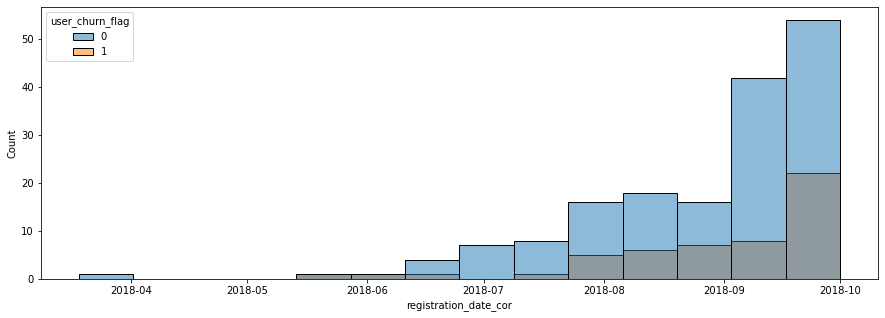

In [199]:
plt.figure(figsize=[15,5])
sns.histplot(data= tenures_churn_comp, x='registration_date_cor',hue='user_churn_flag')

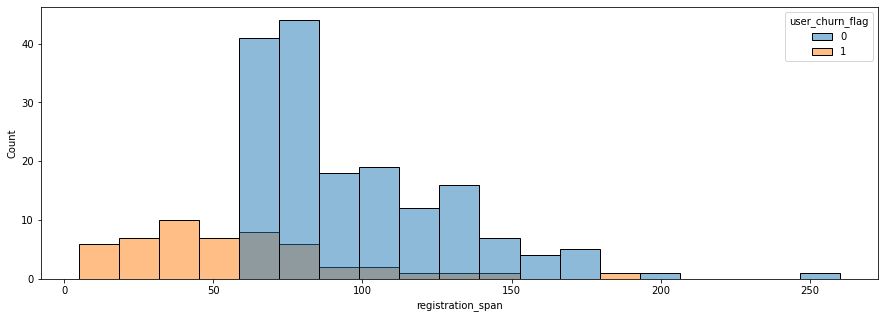

In [200]:
plt.figure(figsize=[15,5])
sns.histplot(data= tenures_churn_comp, x='registration_span',hue='user_churn_flag')

Seems like churning users are using the platform for a much shorter time than not churning ones.
The longer a customer has been registered, teh less likely they will churn.

In [211]:
int_df = user_agg.toPandas().merge(tenures_churn_comp,on=['userId'],how='left')

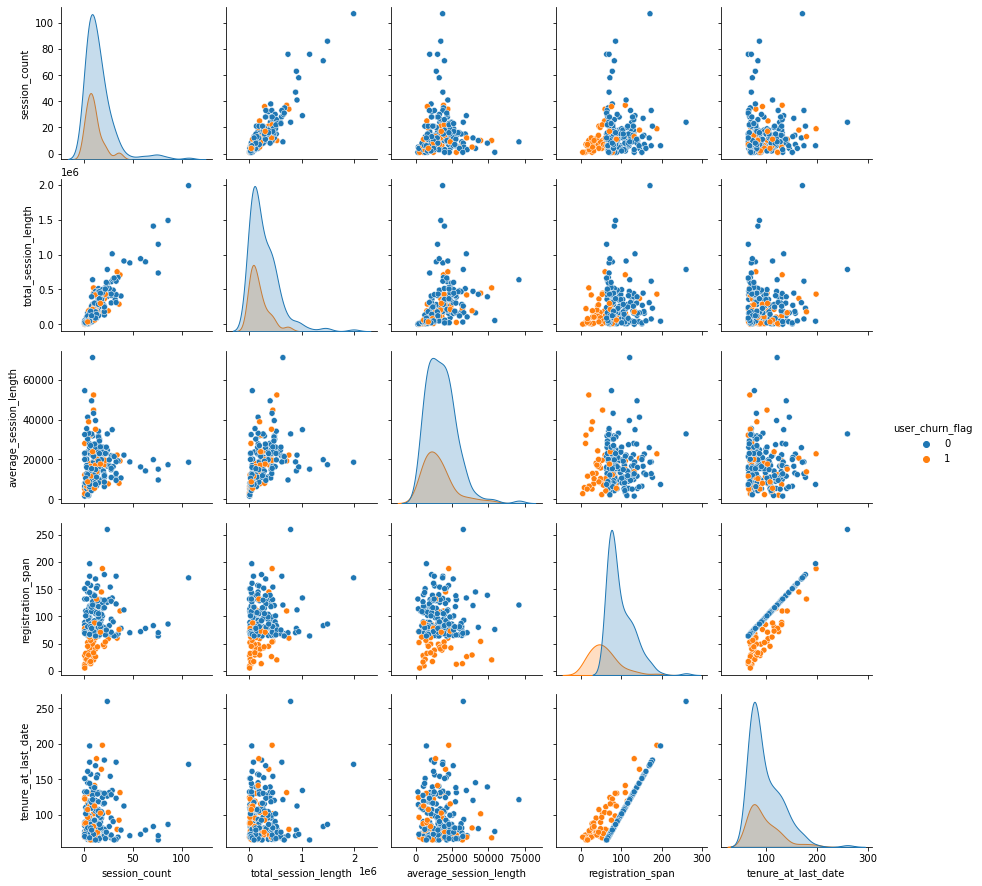

In [212]:
sns.pairplot(int_df.drop(columns = ['userId']), hue='user_churn_flag')

There seems to be a great overlap in the distribution of session count, session length, or average session length between churning and not churning users. However when looking at registration span variable, we see a nice separation, this is due to the definition of teh variable which compares the churn date to the registration_date. 
When lookin at tenure_at_last_date variable, the difference between churning and not churning users disappears.

Let's look at other variables 

In [223]:
gender = df.select('userId','gender', 'user_churn_flag').dropDuplicates()

In [257]:
def plot_churn_rate(var_df,column, userCount):
    df_churn = var_df.filter(col('user_churn_flag')==1)\
                    .select('userId',column)\
                    .groupby(column)\
                    .count()\
                    .withColumnRenamed('count','churned')\
                    .toPandas()
    
    df_total = var_df.select('userId',column)\
                    .groupby(column)\
                    .count()\
                    .withColumnRenamed('count','user count')\
                    .toPandas()
    
    df_to_plot = df_total.merge(df_churn, on=[column], how='left')
    df_to_plot.fillna(0, inplace=True)
    df_to_plot = df_to_plot.sort_values(by=['user count'], ascending = False)
    df_to_plot['churn_rate'] = df_to_plot['churned']/df_to_plot['user count']

    fig, ax = plt.subplots(2,1,figsize=(15,5), dpi = 200)
    sns.barplot(data=df_to_plot, x=column,y='user count',color='g', ax=ax[0]);
    sns.barplot(data=df_to_plot, x=column,y='churn_rate',color='b', ax=ax[1]);
    plt.xticks(rotation=90)

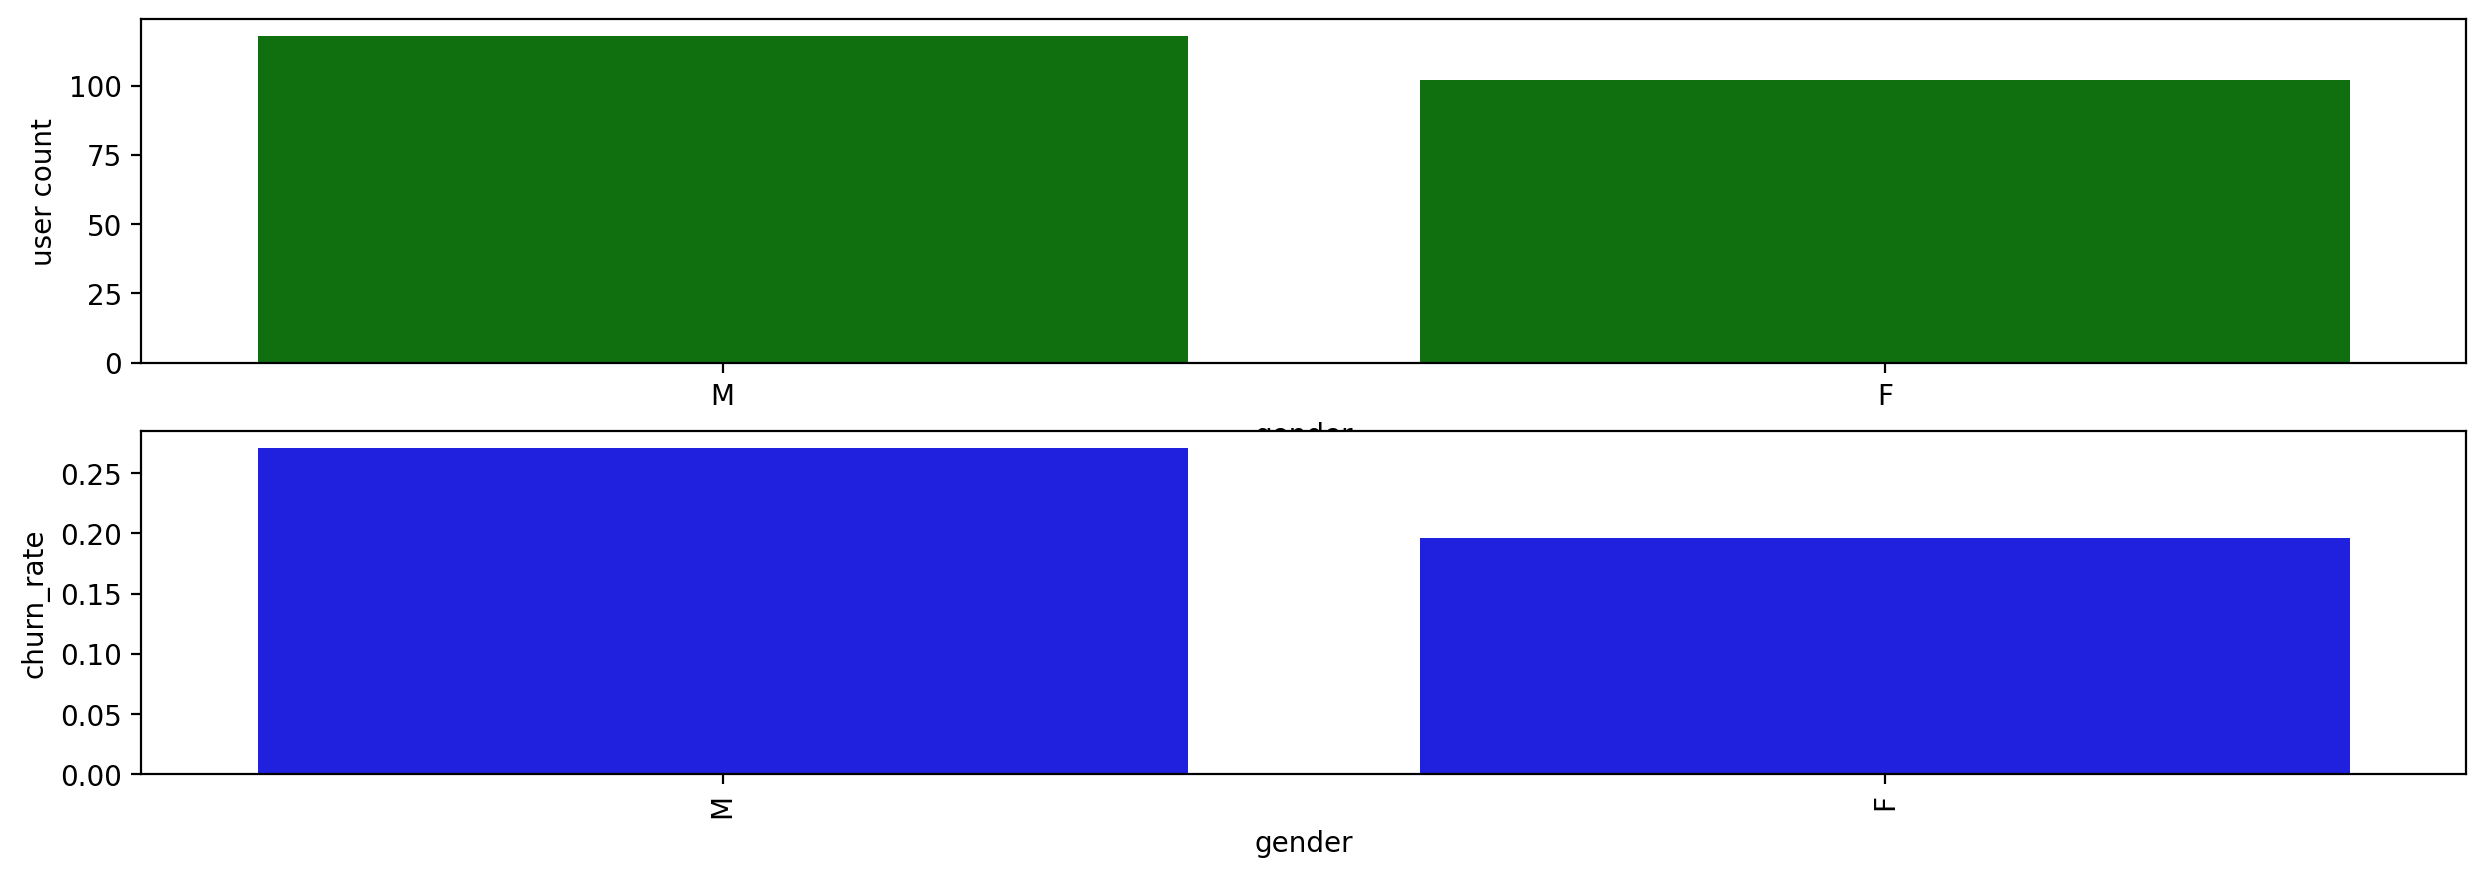

In [258]:
plot_churn_rate(gender,'gender',userCount)

A higher churn rate is observed for Males vs females

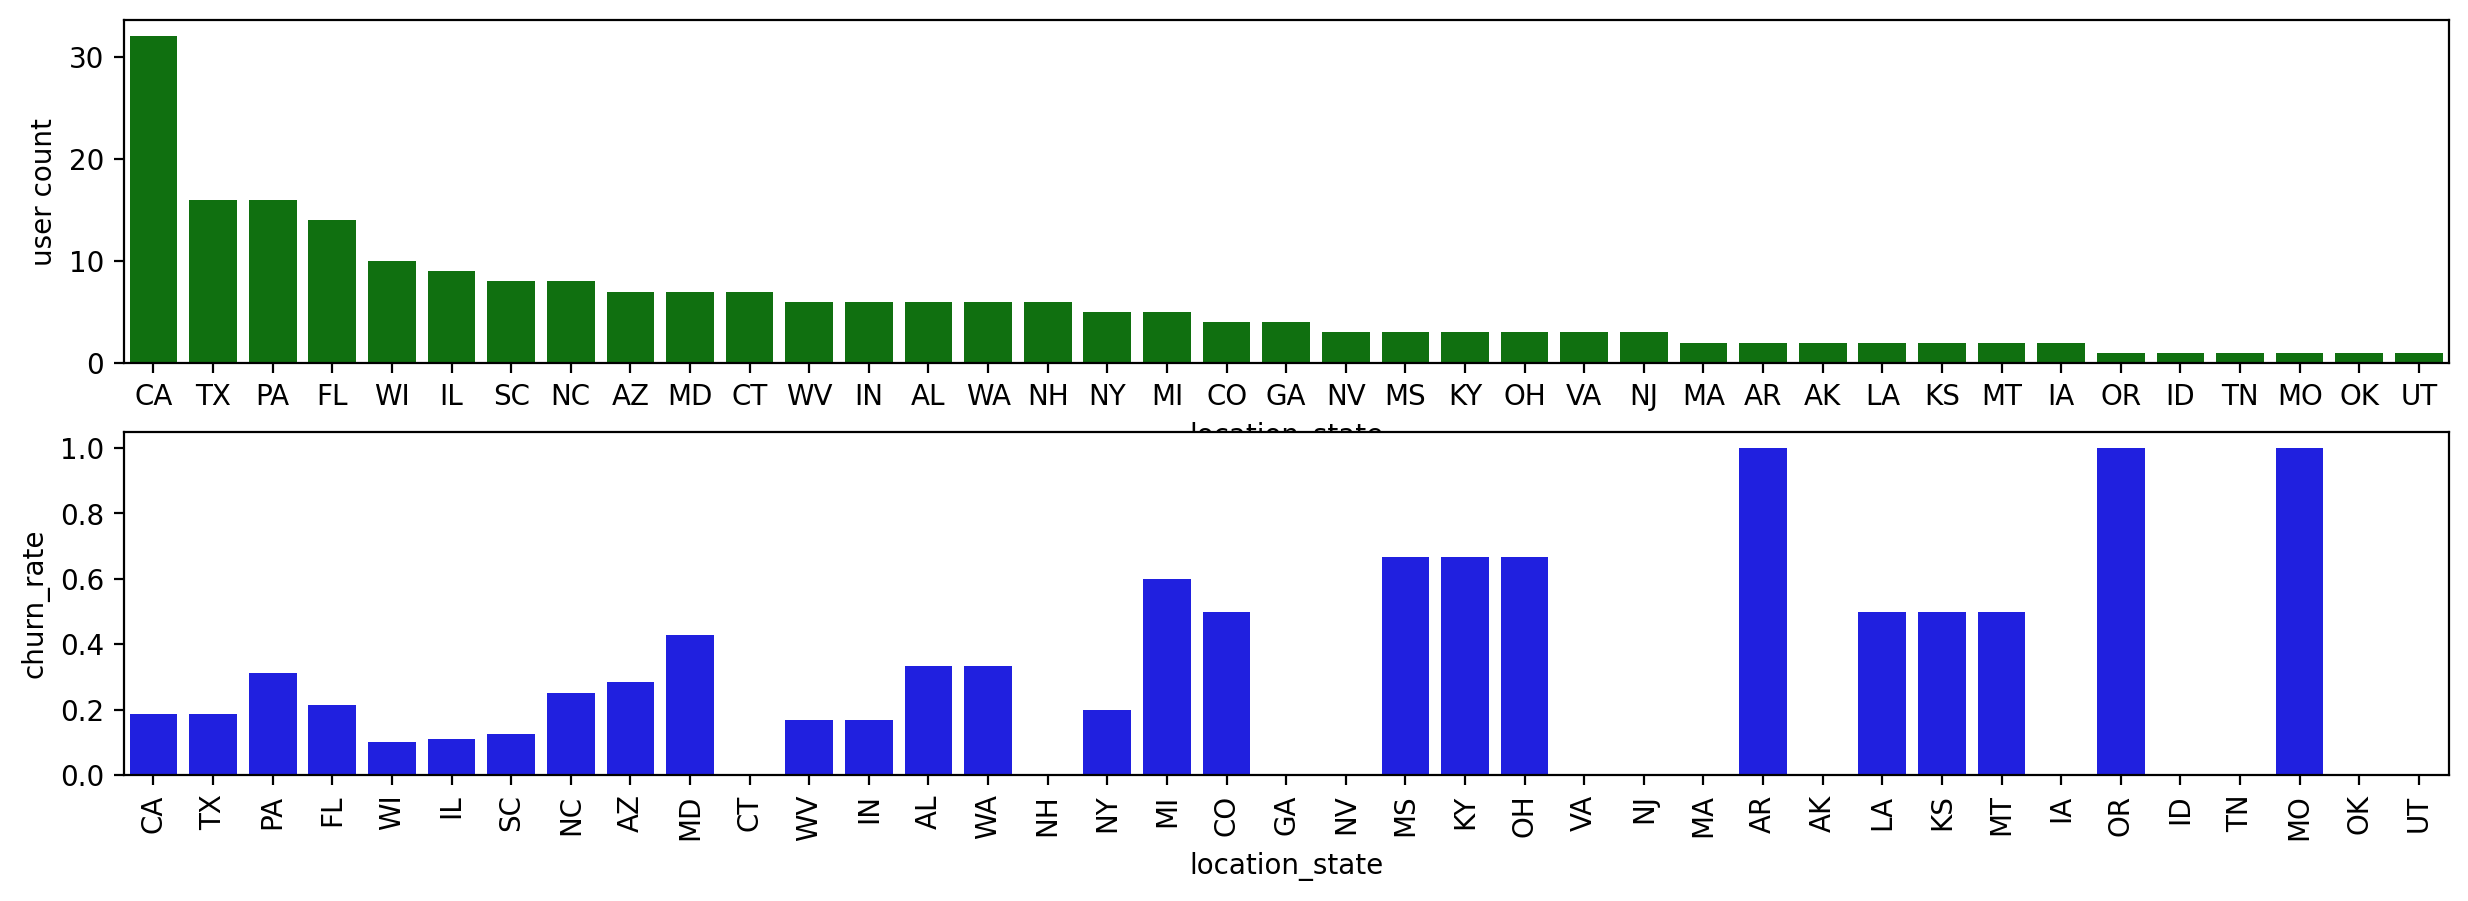

In [259]:
# state and churn
state = df.select('userId','location_state', 'user_churn_flag').dropDuplicates()
plot_churn_rate(state,'location_state',userCount)

The churn rate by states is very variable, and beocmes too noisy for some of the states, one way to help the prediction could be to split states into 5 groups. 
CA, TX, PA, FL and others.

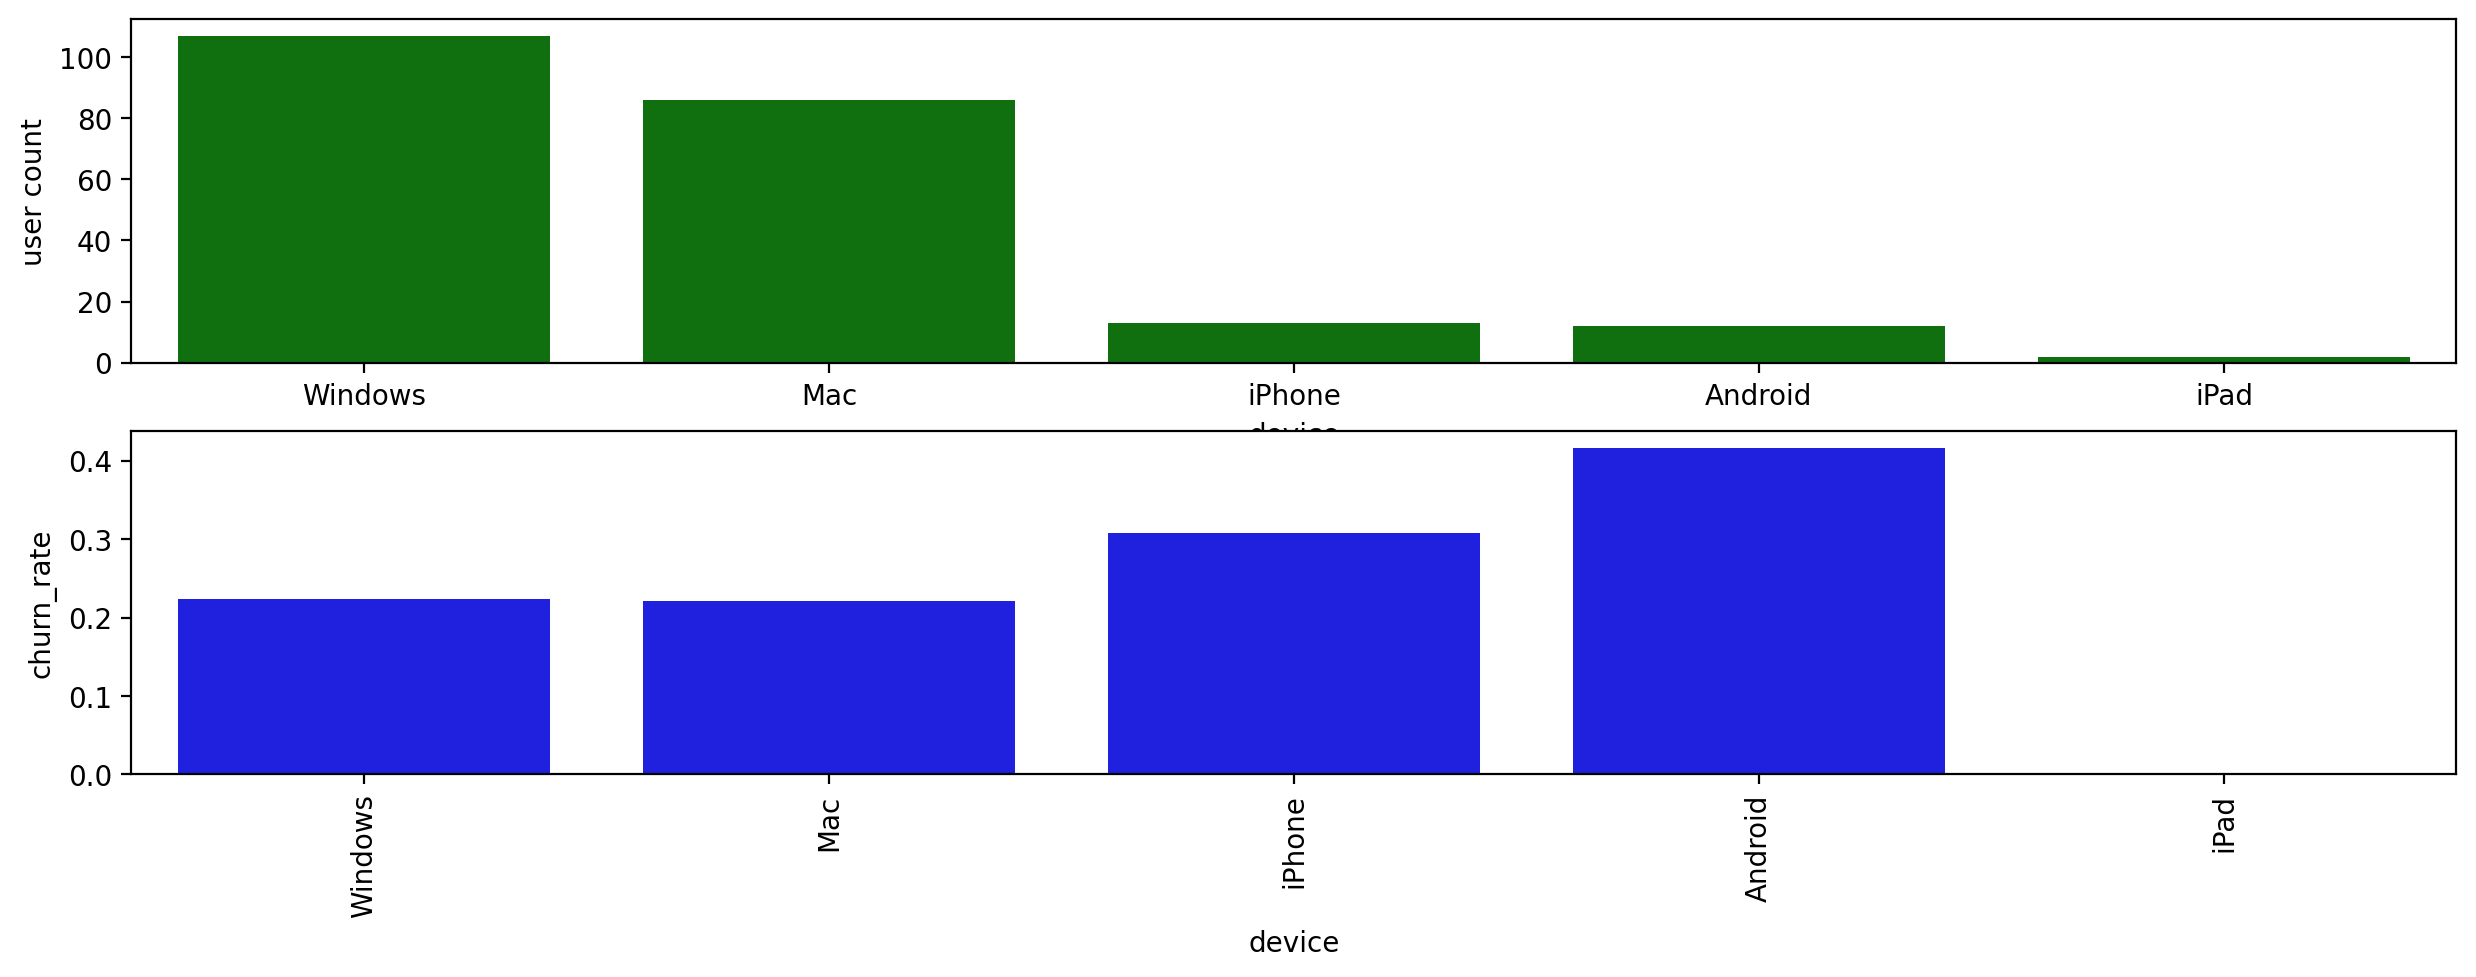

In [260]:
# device and churn
device = df.select('userId','device', 'user_churn_flag').dropDuplicates()
plot_churn_rate(device,'device',userCount)

No ipad owners are churning, but we see a high churn rate for iPhone and Android compared to Windows or Mac users. However since the mobile devices users are so small, it might be risky to draw any conclusion from this data.

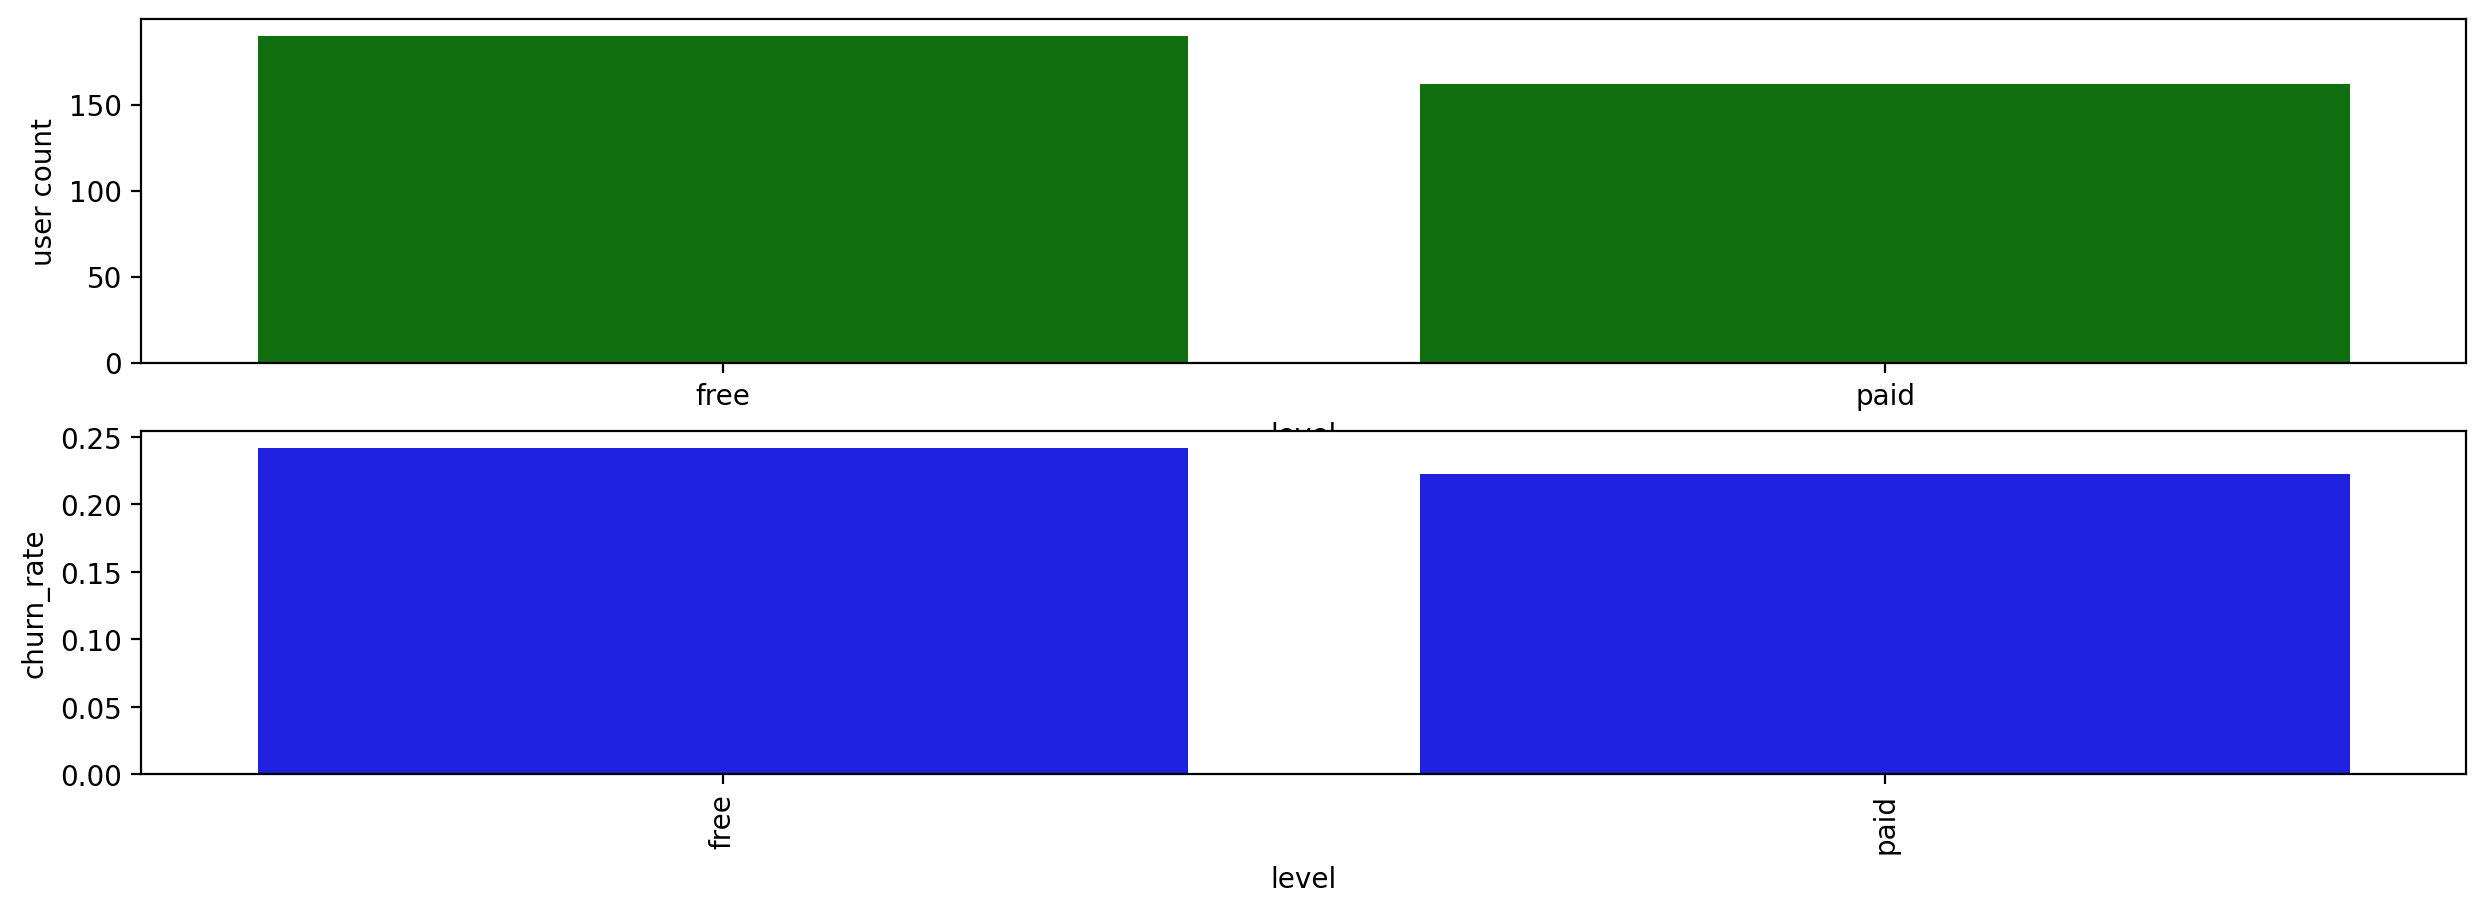

In [261]:
# paid, free offer and churn
level = df.select('userId','level', 'user_churn_flag').dropDuplicates()
plot_churn_rate(level,'level',userCount)

Users haveing used the paid offer are slightly less likely to churn.

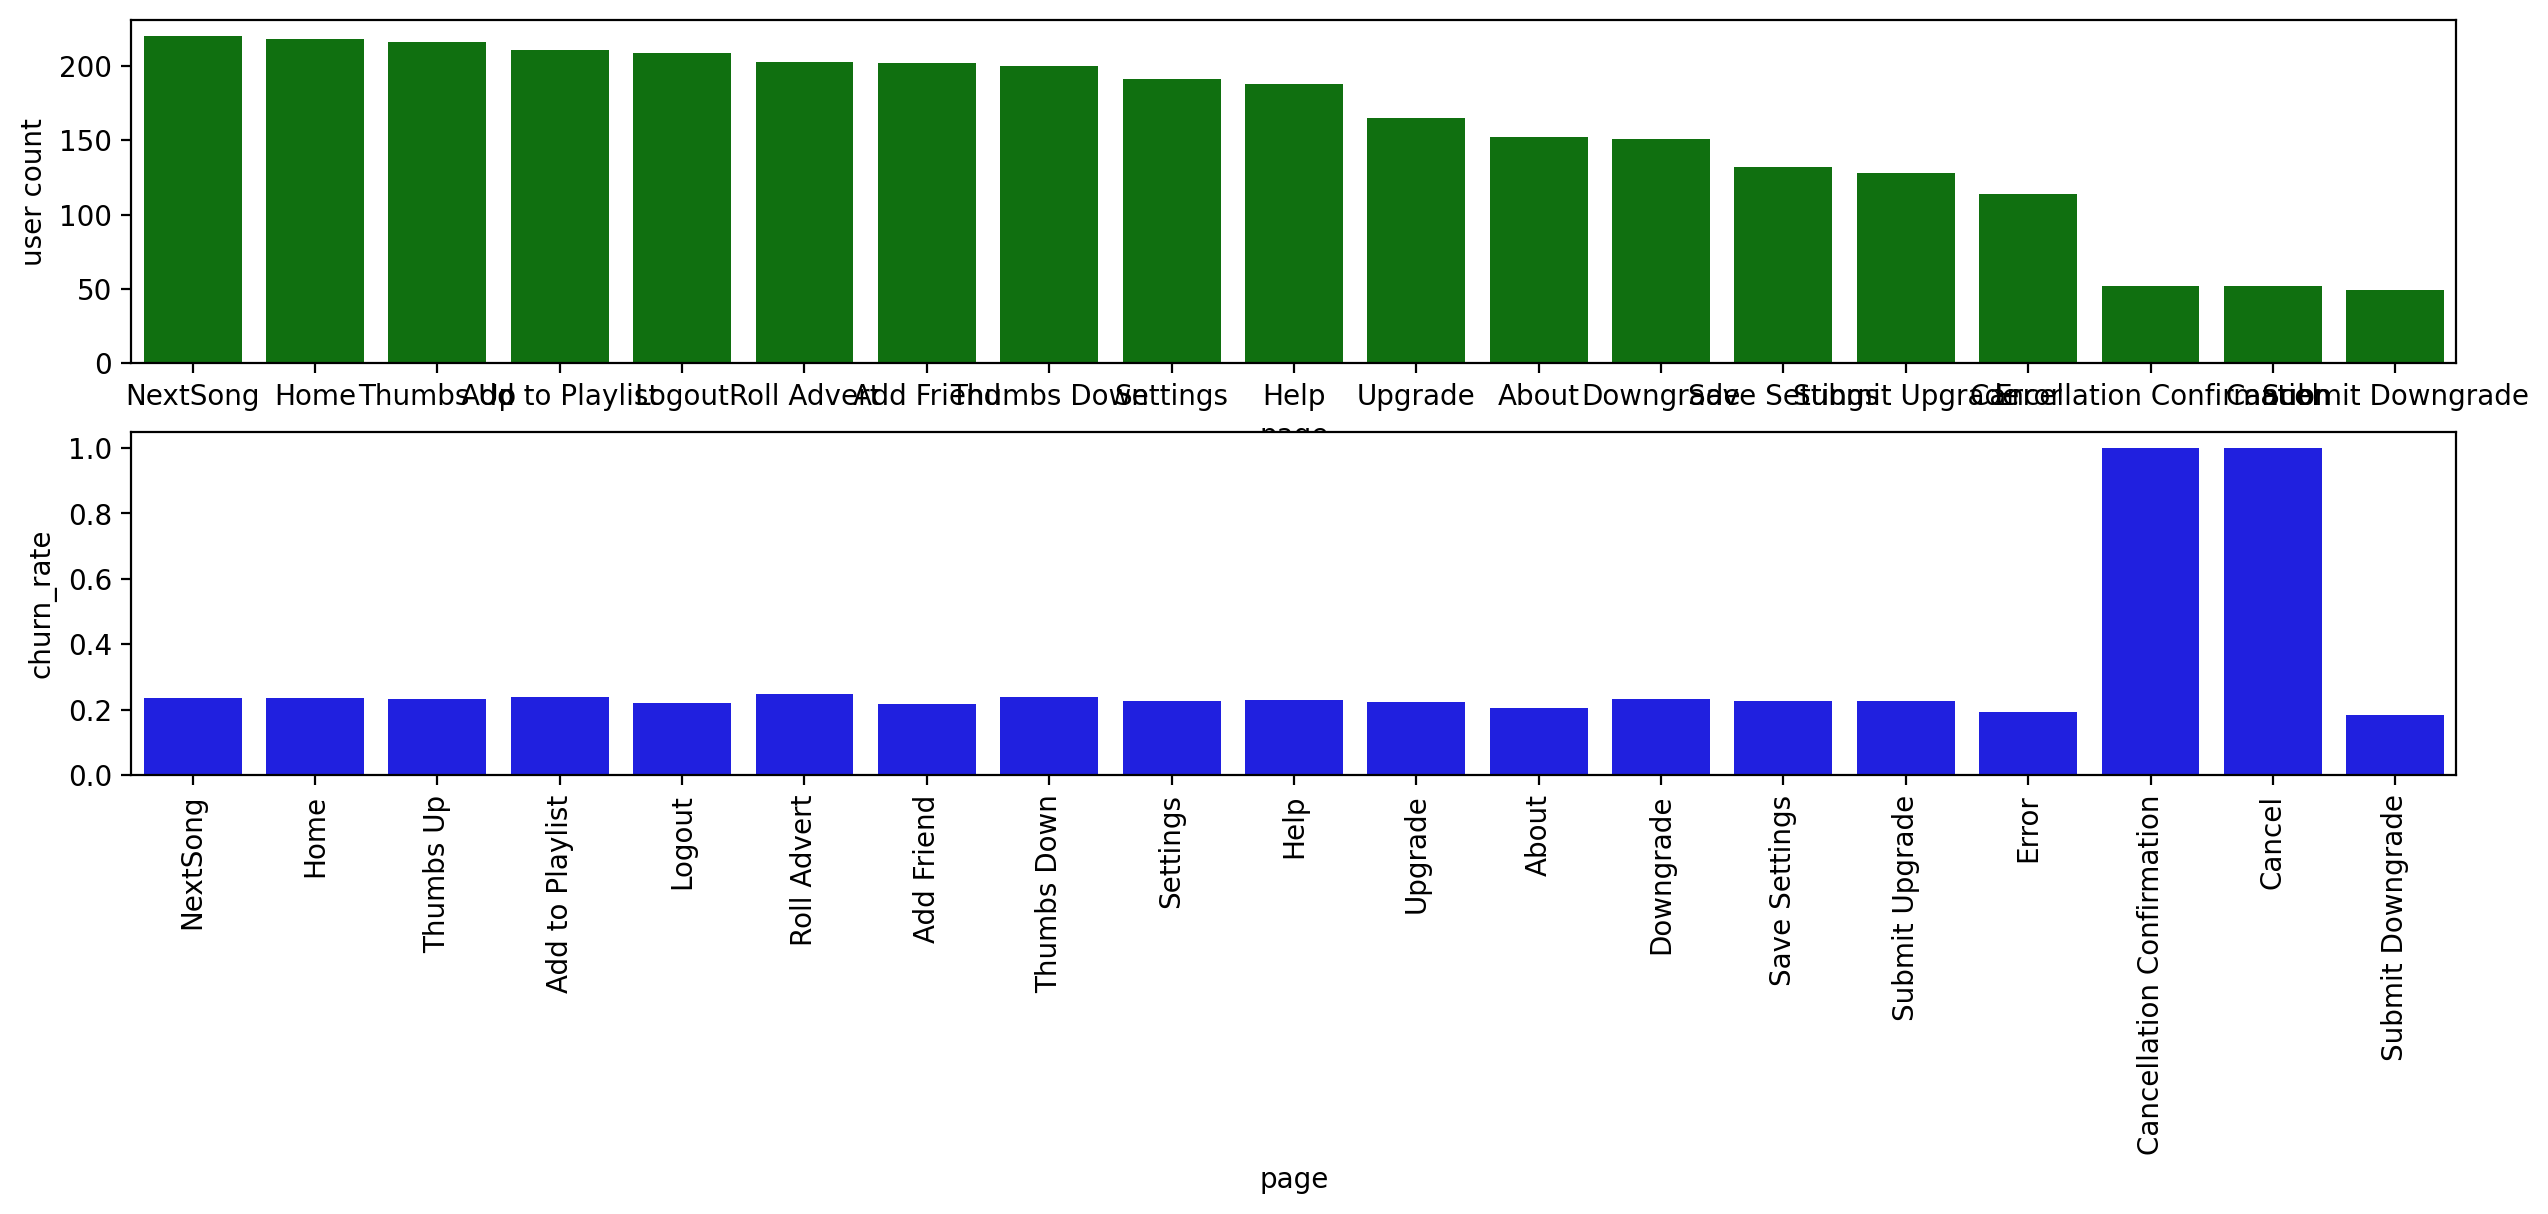

In [262]:
# page usage and churn
page = df.select('userId','page', 'user_churn_flag').dropDuplicates()
plot_churn_rate(page,'page',userCount)

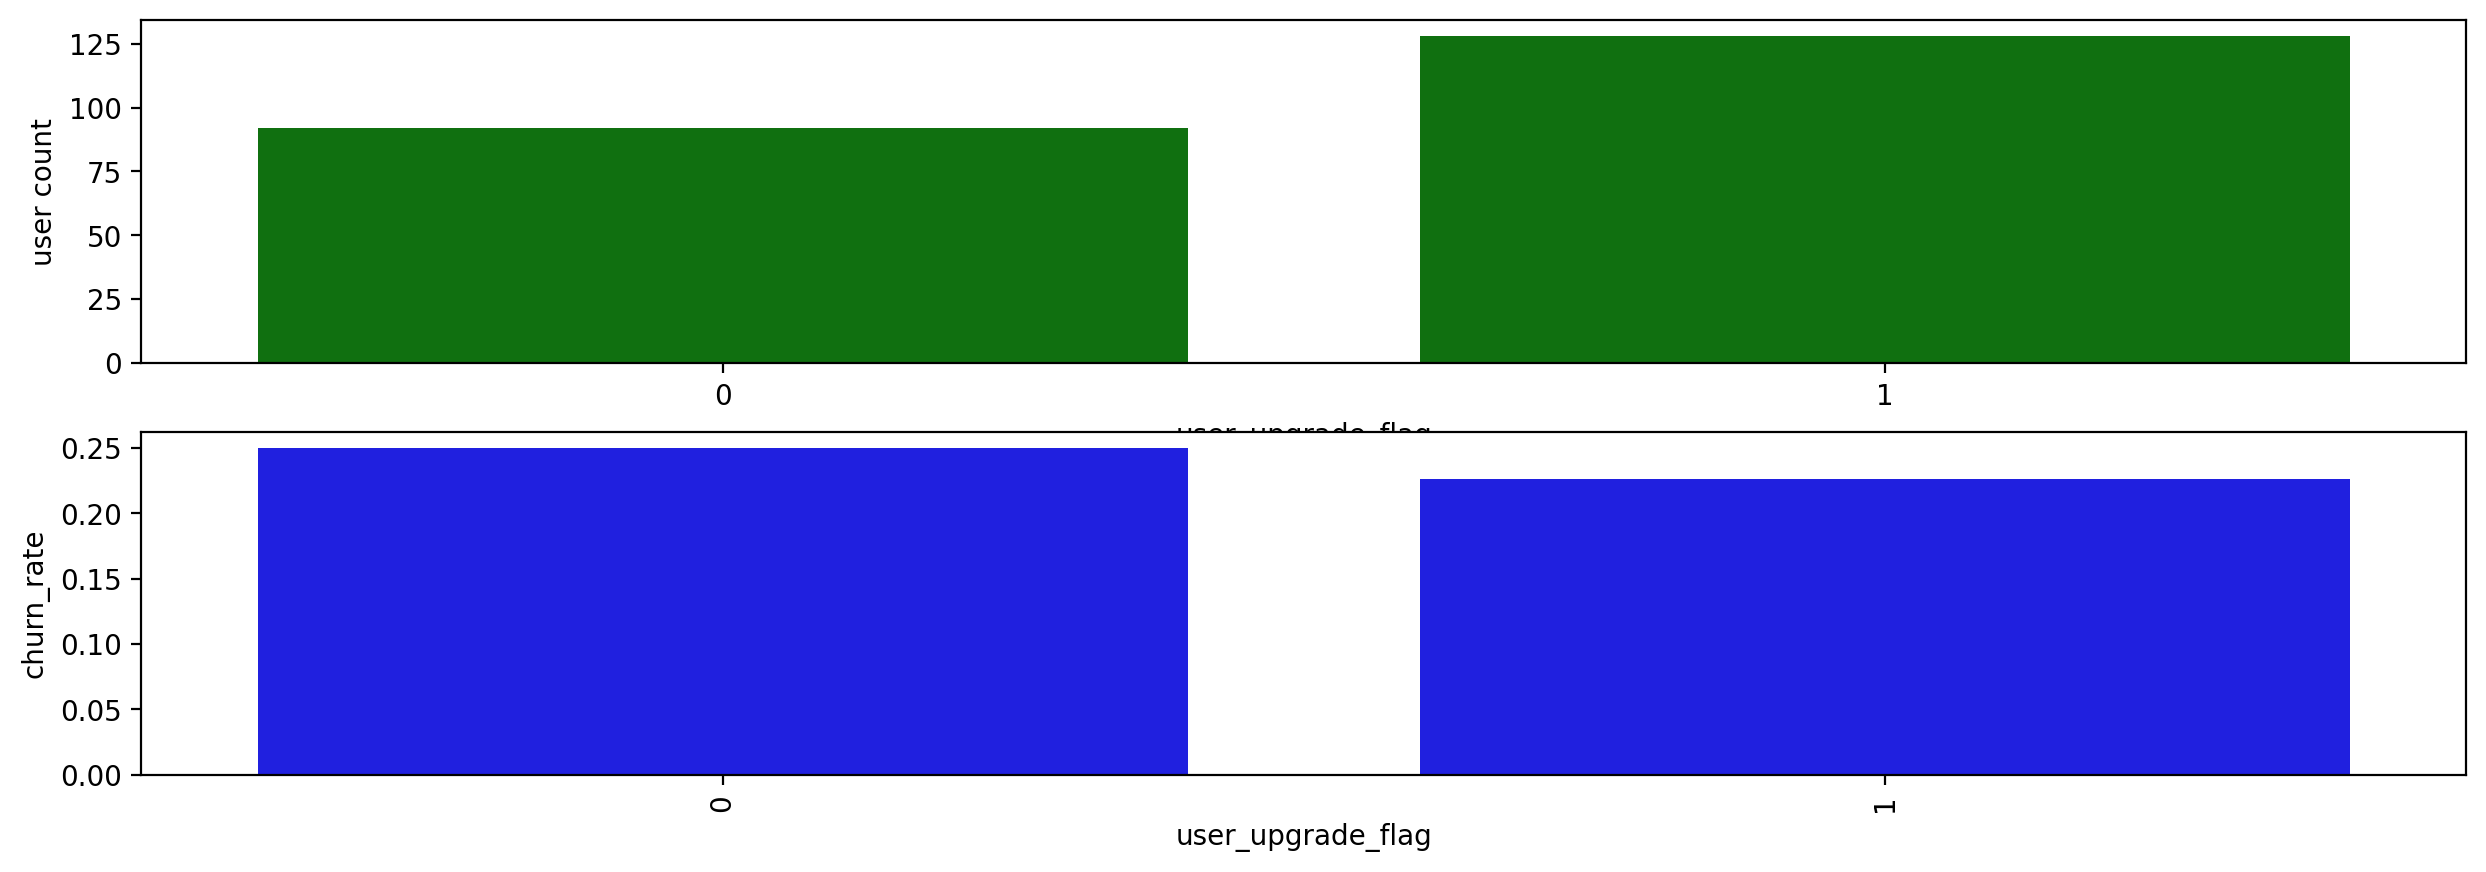

In [264]:
# upgrade and churn
upgrade = df.select('userId','user_upgrade_flag', 'user_churn_flag').dropDuplicates()
plot_churn_rate(upgrade,'user_upgrade_flag',userCount)

There is a slightly higher churn rate for users that do not upgrade.

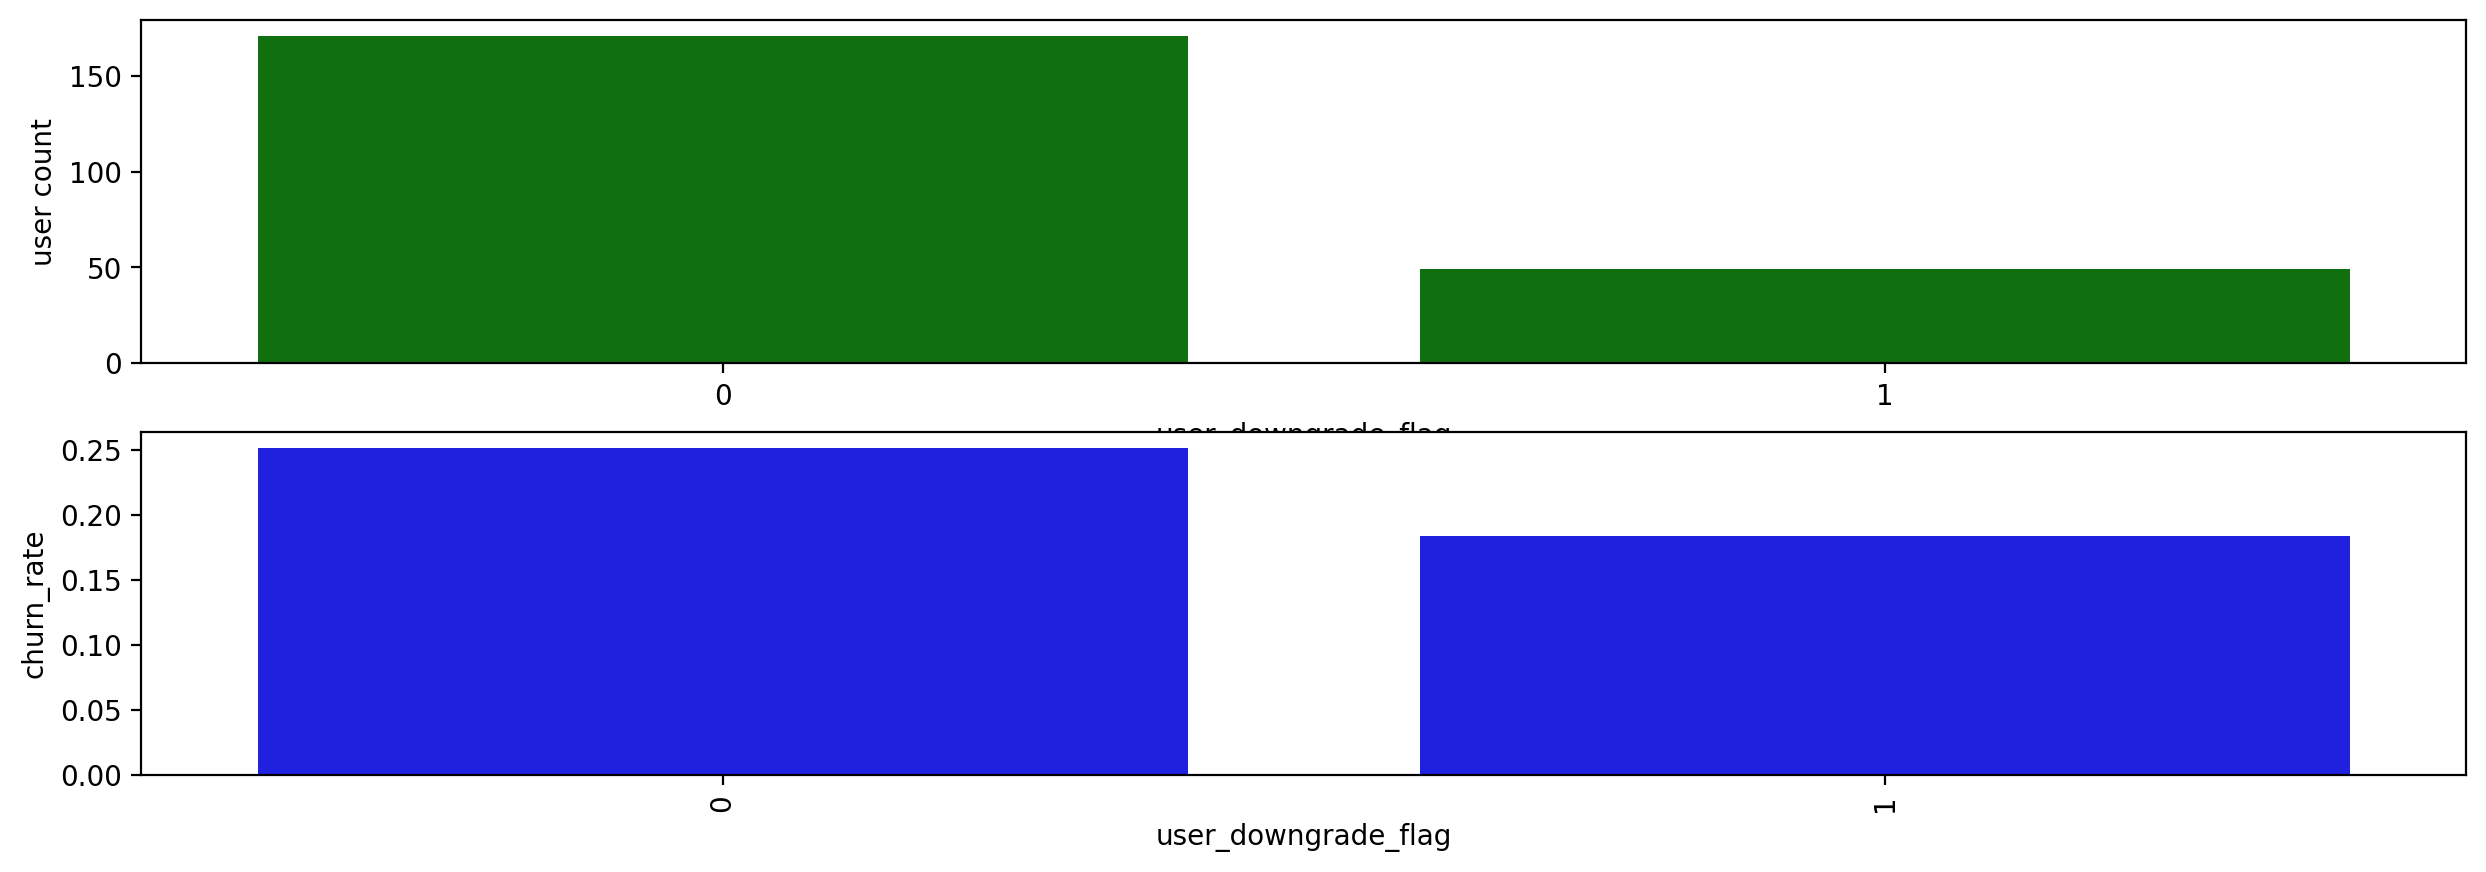

In [265]:
# downgrade and churn
downgrade = df.select('userId','user_downgrade_flag', 'user_churn_flag').dropDuplicates()
plot_churn_rate(downgrade,'user_downgrade_flag',userCount)

But also a slightly higher churn rate for users that do not downgrade.

Let's look more in details into the number of actions per page per user.

In [266]:
# get action count per page visited per user
page_count = df.select("userId", "page").groupBy("userId").pivot("page") \
    .count().drop("Cancel", "Cancellation Confirmation").fillna(0)
page_count.persist()

DataFrame[userId: string, About: bigint, Add Friend: bigint, Add to Playlist: bigint, Downgrade: bigint, Error: bigint, Help: bigint, Home: bigint, Logout: bigint, NextSong: bigint, Roll Advert: bigint, Save Settings: bigint, Settings: bigint, Submit Downgrade: bigint, Submit Upgrade: bigint, Thumbs Down: bigint, Thumbs Up: bigint, Upgrade: bigint]

In [269]:
page_count = page_count.join(df.select('userId','user_churn_flag').dropDuplicates(), on=['userId'], how='left')

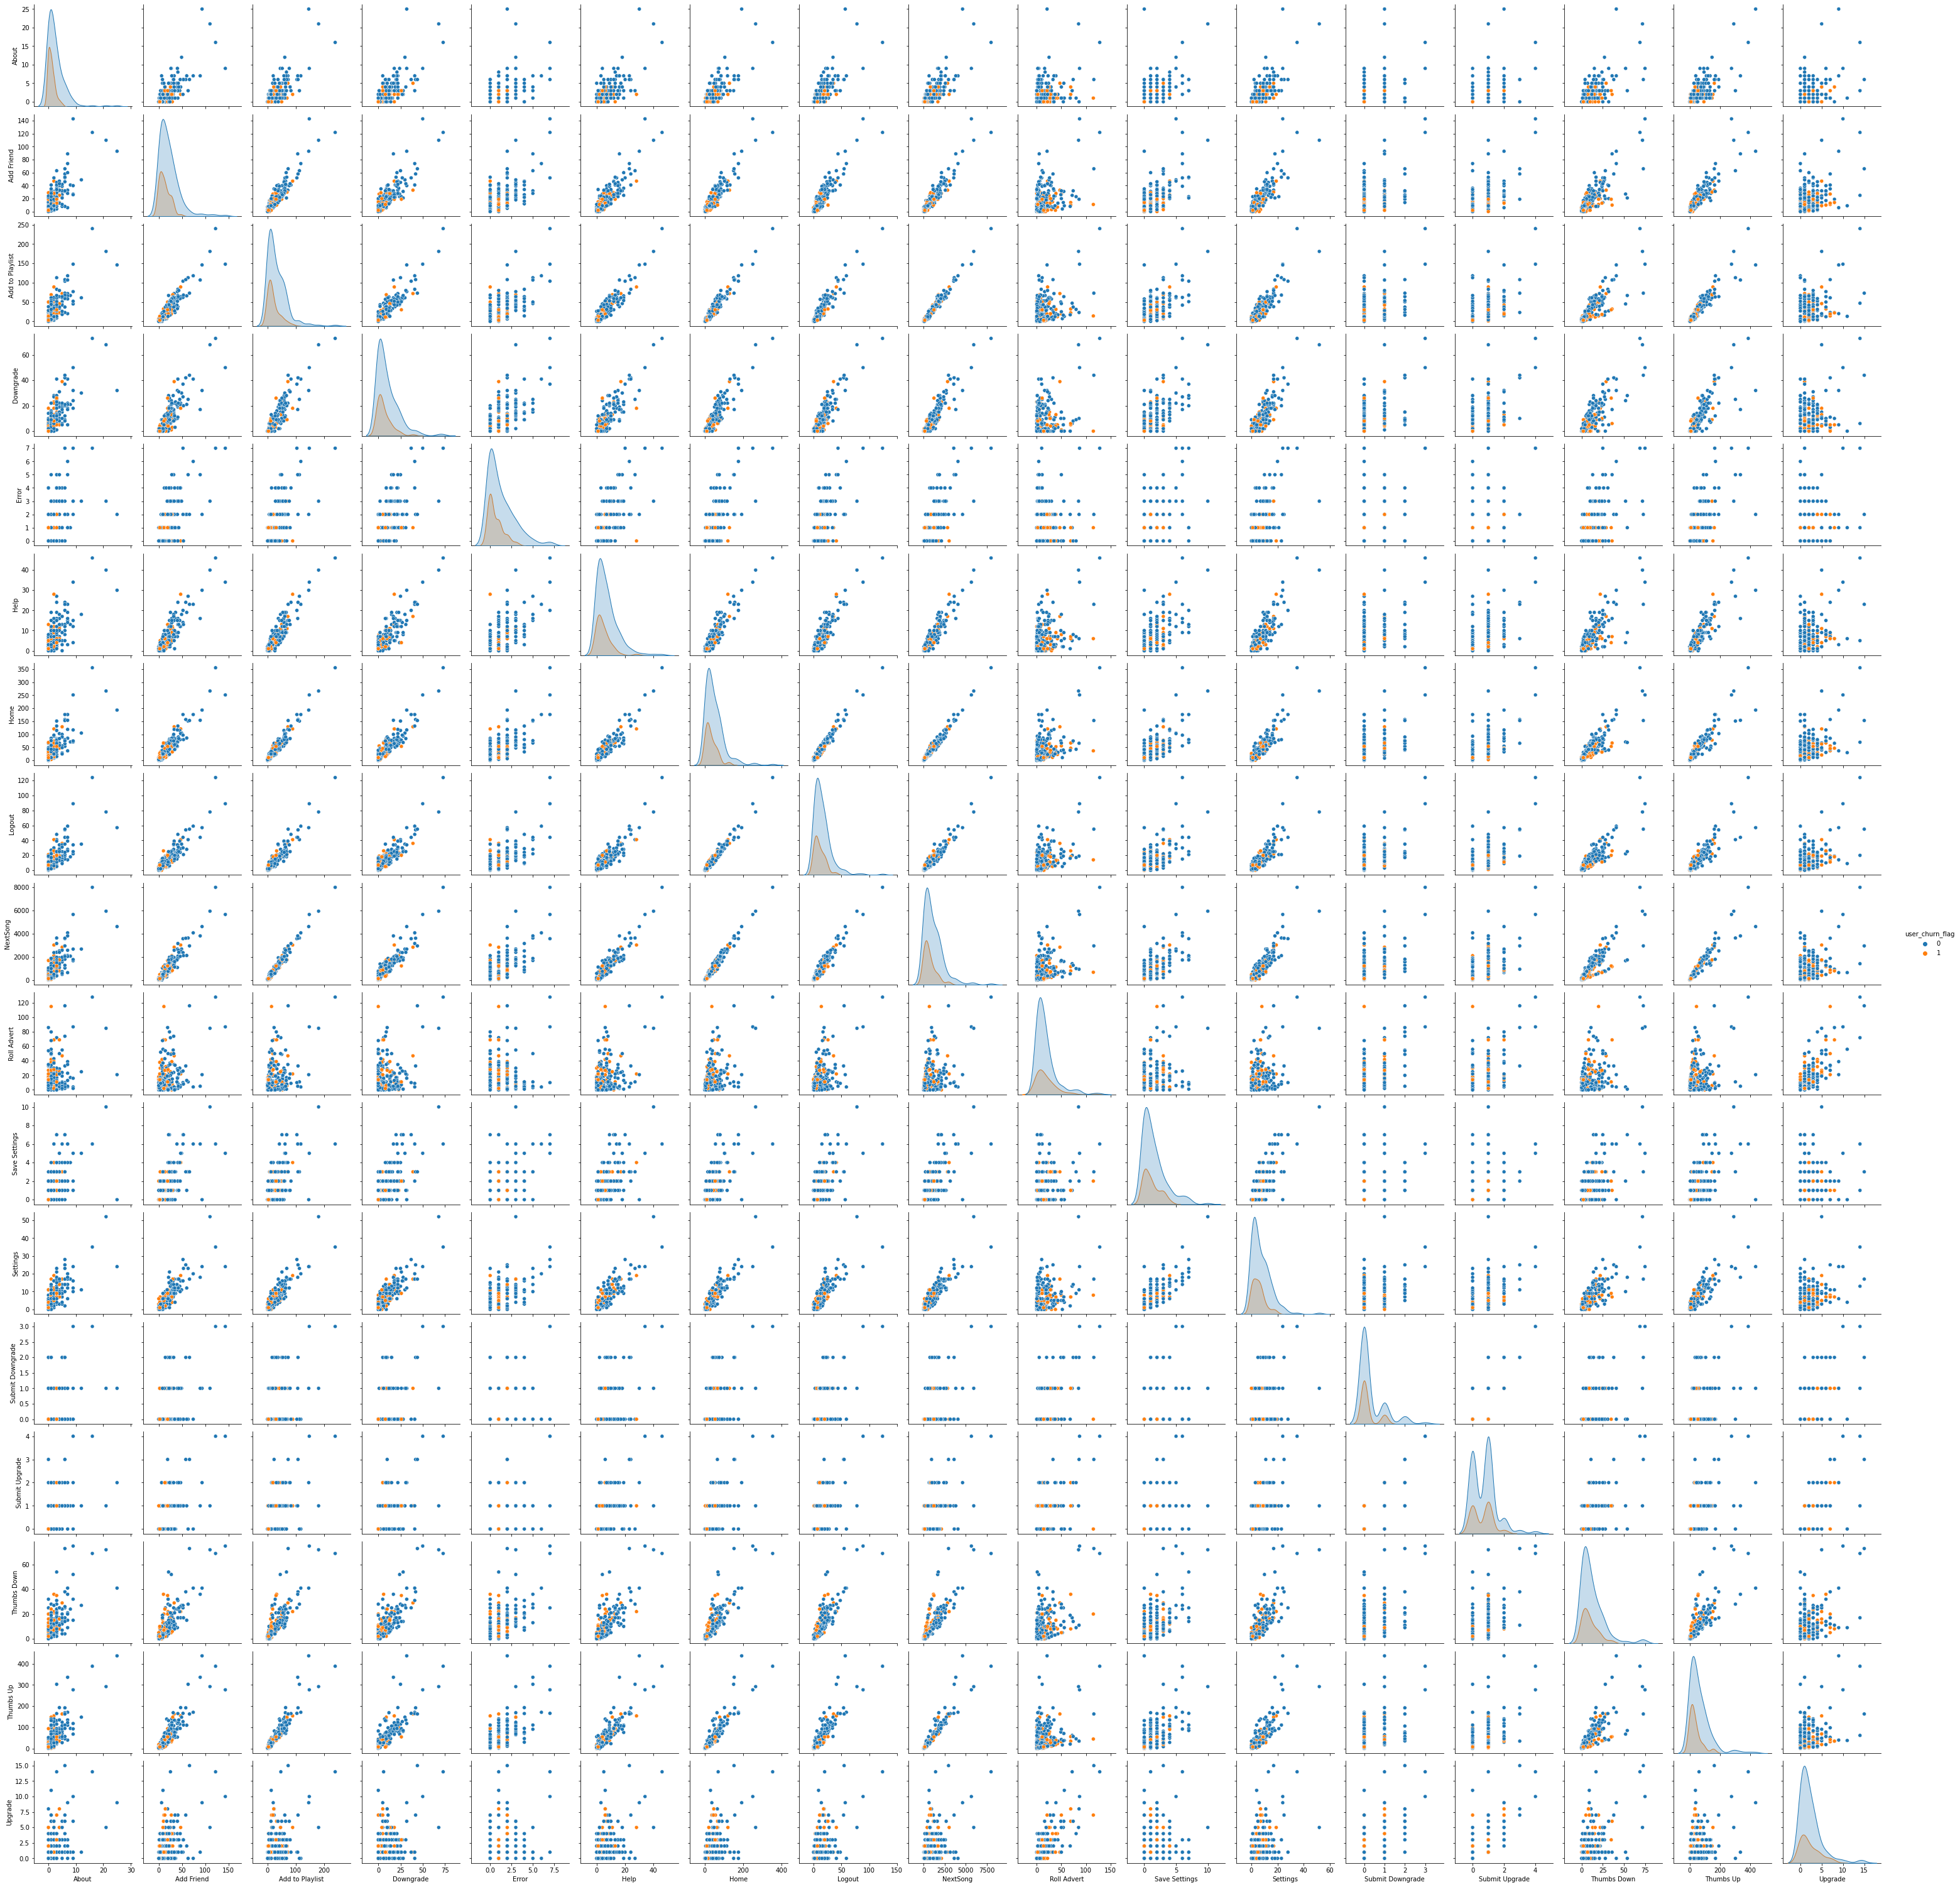

In [270]:
sns.pairplot(page_count.drop('userId').toPandas(),hue='user_churn_flag')

There seems to not be many features that show a clear separation between users churning and users not churning, however, in the page count, the usage of thumbs_up, thumbs_down and Add to playlist seem to have a differnet correlation slope depending on when the users are churning vs not, so those could be good predictors for our model.

Let's look at how those slopes change when we normalize by the number of sessions.

In [274]:
def add_features(df1,df2):
    df1 = df1.join(df2,'userId')
    return df1

In [275]:
def get_actions_per_session(user_agg,df_user_sessions,page_count):
    
    for p in page_count.columns[1:]:
        actions = page_count.select('userId',p)
        new_col_name = '_'.join(p.split(' '))+'_per_session'
        
        actions_per_session = actions.join(df_user_sessions,'userId')\
                            .withColumn(new_col_name, col(p)/col('session_count'))\
                            .drop(p)\
                            .drop('session_count')
        
        user_agg = add_features(user_agg, actions_per_session)
        
    return user_agg

In [276]:
# Add action page count per session 
df_user_sessions = user_agg.select('userId','session_count')
df_user_sessions.persist()
page_per_session = df.select('userId','user_churn_flag').dropDuplicates()
page_per_session = get_actions_per_session(page_per_session,df_user_sessions,page_count)
page_per_session.persist()

DataFrame[userId: string, user_churn_flag: int, About_per_session: double, Add_Friend_per_session: double, Add_to_Playlist_per_session: double, Downgrade_per_session: double, Error_per_session: double, Help_per_session: double, Home_per_session: double, Logout_per_session: double, NextSong_per_session: double, Roll_Advert_per_session: double, Save_Settings_per_session: double, Settings_per_session: double, Submit_Downgrade_per_session: double, Submit_Upgrade_per_session: double, Thumbs_Down_per_session: double, Thumbs_Up_per_session: double, Upgrade_per_session: double, user_churn_flag_per_session: double]

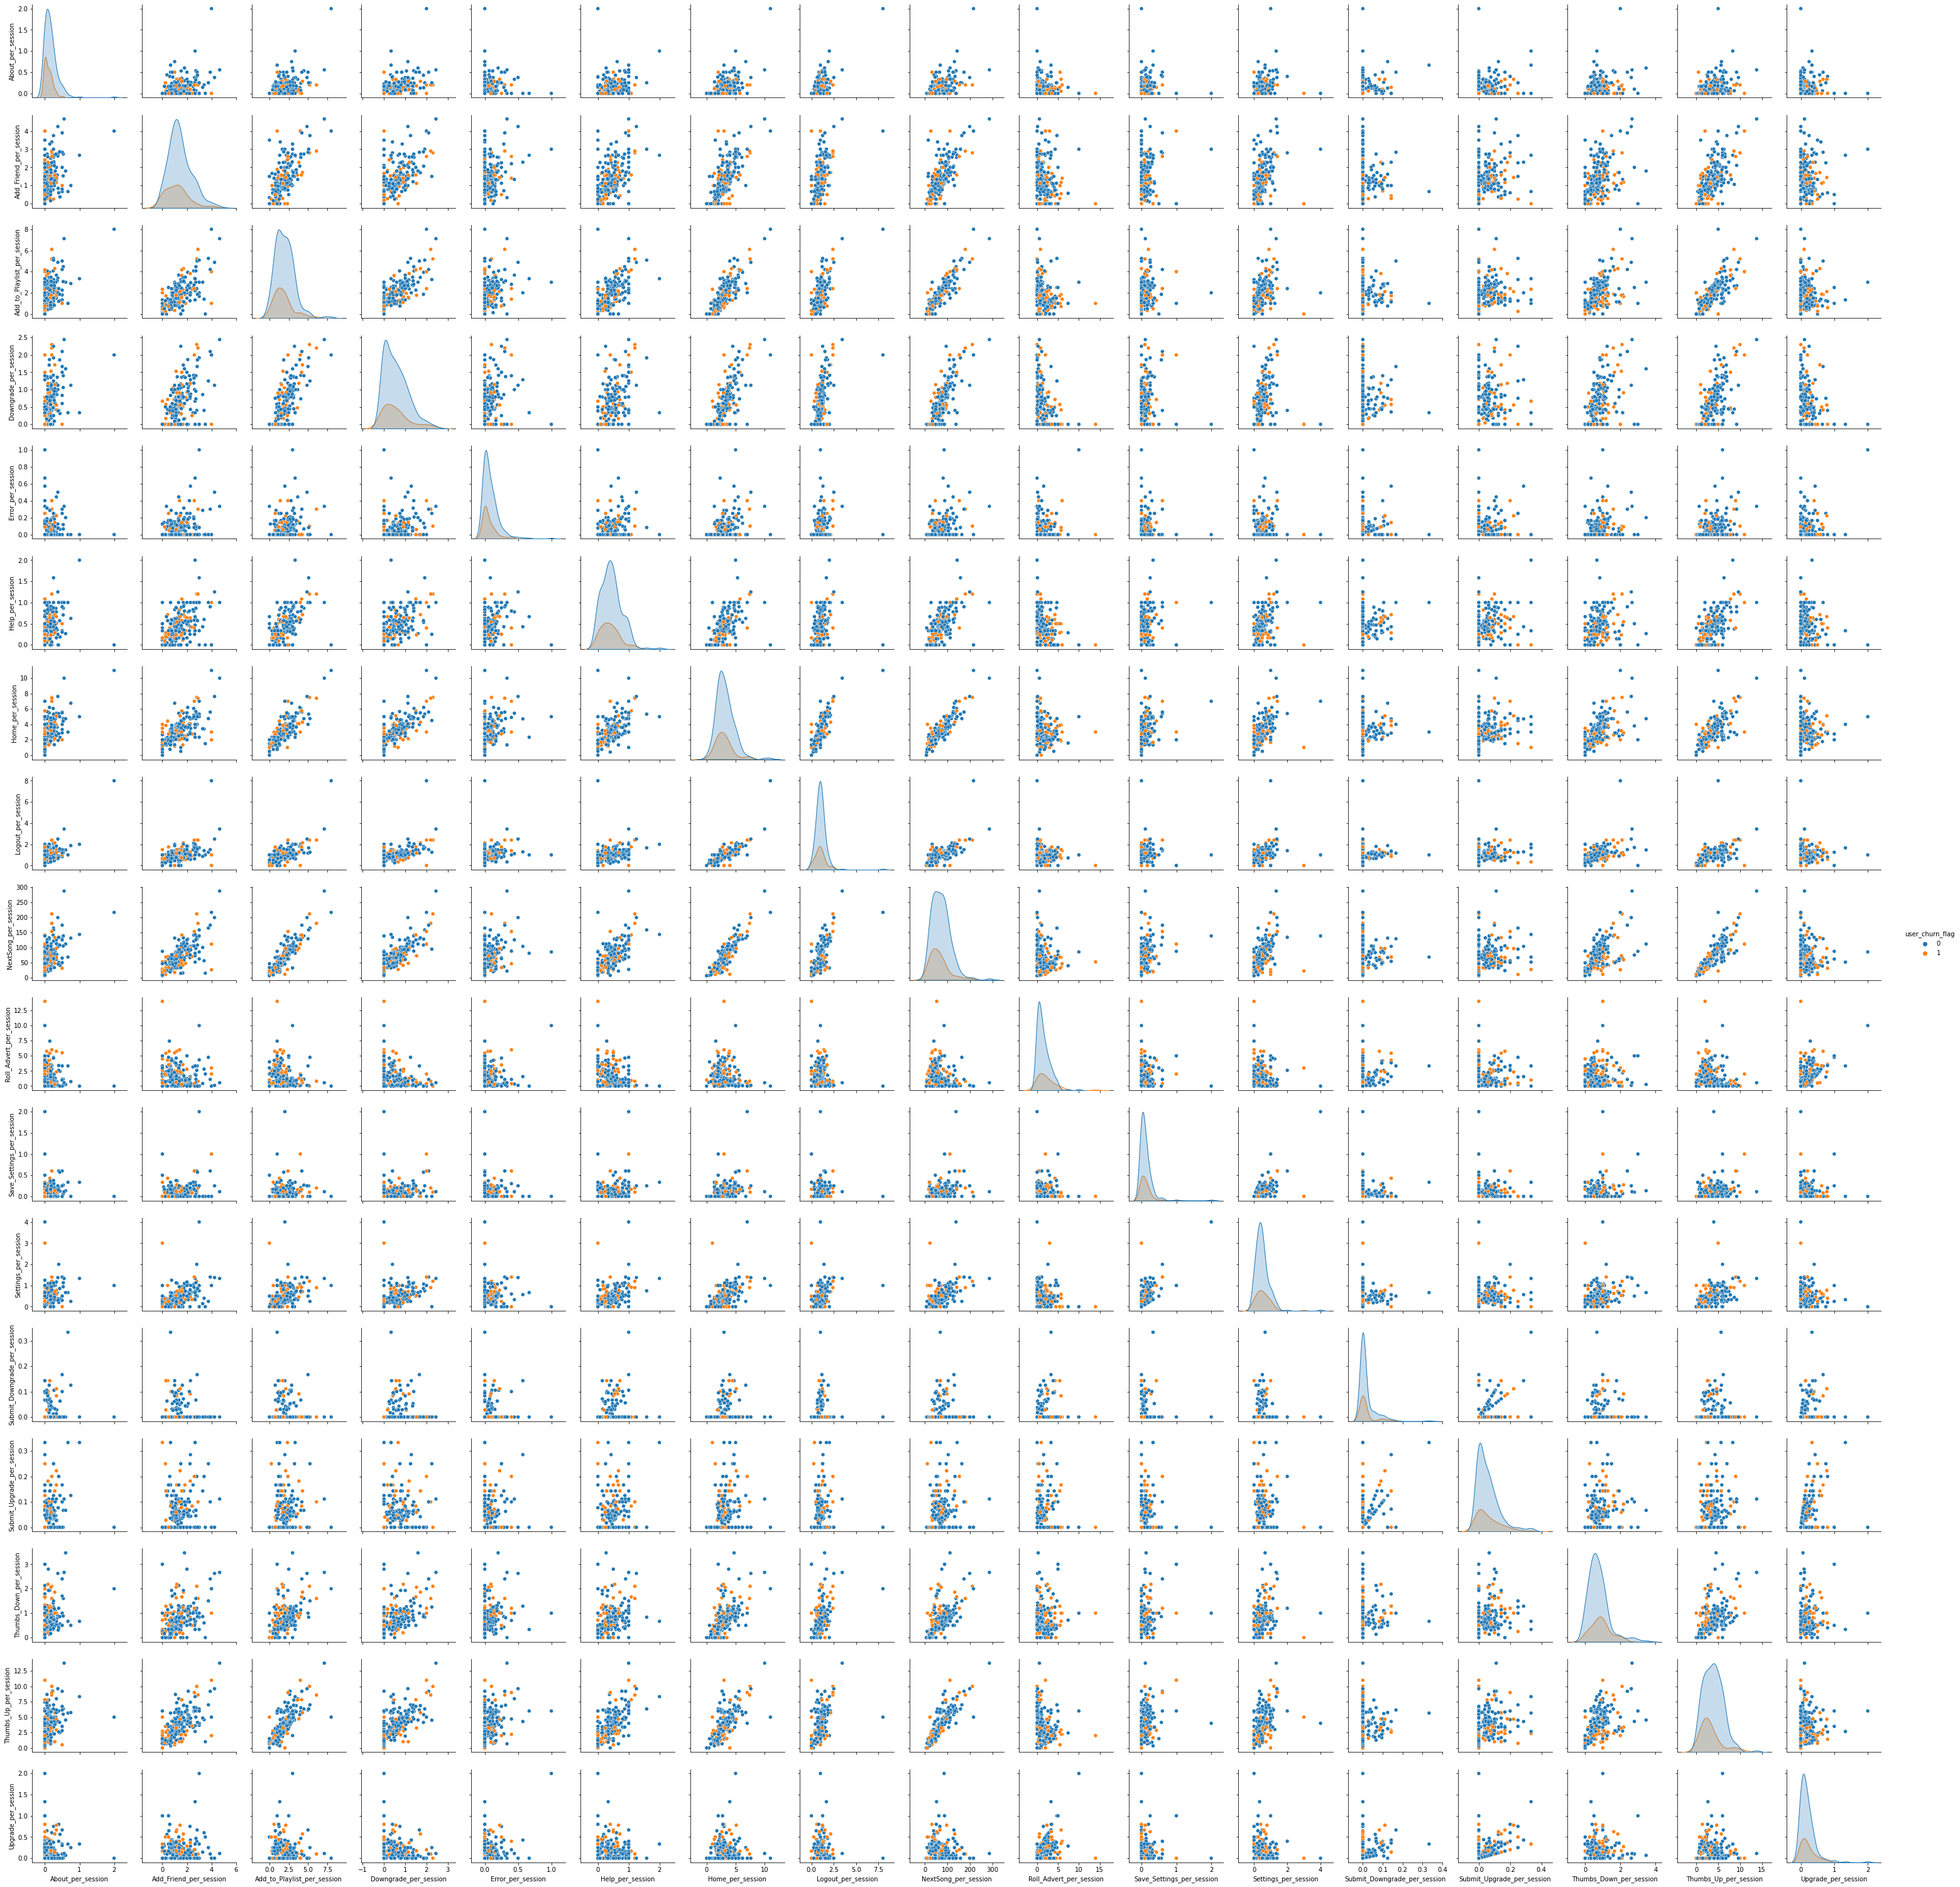

In [284]:
sns.pairplot(page_per_session.drop('userId').drop('user_churn_flag_per_session').toPandas(),hue='user_churn_flag')

From the deep exploratory data analysis done here, there seems to be collection of interesting features that may help predict churning behaviors.
Normailizing by the session does not seem to add clarity, so we can just look at overall numbers in the feature engineering part.
Thumbs_up and thumbs_down seems to help predicting churning behaviors.

The feature engineering will be done in the next notebook. 

Maybe to be used:

In [81]:
topArtists_df = df.select('artist').groupby('artist').count().orderBy(desc('count')).select('artist').dropna().toPandas()

In [82]:
top10artists = topArtists_df.artist[:10].tolist()